## 1. Import Libraries

In [18]:
import os
import mne
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.io import loadmat
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import ttest_rel, ttest_ind
from IPython.display import clear_output
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from matplotlib.colors import TwoSlopeNorm
from mne.time_frequency import tfr_multitaper, tfr_array_multitaper, csd_multitaper
from tensorpac import Pac, EventRelatedPac
from tensorpac.utils import ITC
import matplotlib.patches as mpatches
from scipy.interpolate import interp1d
from mne.time_frequency import EpochsSpectrum
import math
import scipy.io as io

from mne.time_frequency import tfr_multitaper
from mne_connectivity import spectral_connectivity_time, spectral_connectivity_epochs
from mne_connectivity.viz import plot_connectivity_circle

%matplotlib inline
%config InlineBackend.figure_format='retina'

## 2. Load Preprocessed Data
Pulls information from:
Pull information from AMME datafiles per subject that are preprocessed:
- PreprocessedData/subject_respcondition.npy: numpy array of response condition for that subject (1-yes, 0-no responses extracted from log files)
- PreprocessedData/subject_stimcondition.npy: numpy array of stimulation condition (PNAS: 1-stim 0-nostim, 9-new; Duration: 1-onesec stim, 3-threesec stim, 0-nostim, 9-new; Timing: 1-before stim, 2-during stim, 3-afterstim, 0-nostim, 9-new)
- PreprocessedData/ChanLabels.csv: channel labels for usable channels (DroppedChans.csv shows the dropped channel labels after visual inspection)
- PreprocessedData/PreprocessedData.npy: the epoched, filtered, and downsampled (fs=500) lfp data (DroppedEpochs.csv shows the dropped epochs after visual inspection)
- PreprocessedData/Events.npy: numpy array of events IDs for recreating epochs

Check to make sure that the file names for each files called in match. Filenames are inconsistent throughtout the AMME dataset.

In [19]:
# Params
verbosity = 0  # control output verbosity

# Define path for locating & saving data
projDir = '/Users/martinahollearn/Library/CloudStorage/Box-Box/InmanLab/AMME_Data_Emory/AMME_Data'
subject = 'amyg007'
datapath = os.path.join(projDir, subject)
preproDataPath = os.path.join(datapath, 'PreprocessedData')
my_preprocessing_path = os.path.join(preproDataPath, 'Joes_preprocessing')
savepath = os.path.join(my_preprocessing_path, 'LFP_analysis_results')
logfile_path = os.path.join(datapath, f'{subject}_day2.log') #make sure log file name matches
event_filename = f'{subject}_LFP_day2_trialtimes.mat'
events_path = os.path.join(datapath, subject, event_filename)

# Create results folder if it doesn't exist
if not os.path.exists(savepath):
    os.mkdir(savepath)

try:
    # Load preprocessed data
    data = np.load(os.path.join(my_preprocessing_path, 'PreprocessedData.npy'))
    events = np.load(os.path.join(my_preprocessing_path, 'Events.npy'))
    chans = pd.read_csv(os.path.join(my_preprocessing_path, 'ChanLabels.csv'), index_col=0)['Chan'].to_list()
    bad_chans = pd.read_csv(os.path.join(my_preprocessing_path, 'DroppedChans.csv'), index_col=0)['Dropped Chans'].to_list()
    bad_epochs= pd.read_csv(os.path.join(my_preprocessing_path, 'DroppedEpochs.csv'), index_col=0)['Dropped Epochs'].to_list()
    print(bad_epochs)
except:
    print('Error loading data')
    raise


[]


### 2.1 Create `MNE` Objects

In [20]:
# Create MNE object for all channels
info = mne.create_info(ch_names = chans, ch_types = 'seeg', sfreq=500, verbose = verbosity)
n_chans = len(info.ch_names)

ROIs = {
    'Hipp': ['LAHd3'],
    'BLA': ['LAmyd2'],
    'EC': [],
    'PRC': [],
    'PHG': [],
    'MTL': [], # Leave this empty. Will be auto computed in a few lines below
}

# Add all channels to the 'all'
for roi_name in ROIs.keys():
    if roi_name != 'MTL':
        ROIs['MTL'] += ROIs[roi_name]


for roi_name, roi_channels in ROIs.items():
    # Skip processing if we don't have any channels.
    if roi_channels == []:
        continue

    print(f"==== Preprocessing ROIs: {roi_name}")

    np.save(os.path.join(my_preprocessing_path, f'ROI_{roi_name}_channels.npy'), np.array(roi_channels)) #save the ROI channels
    print(f"Manually specified ROI {roi_name} channels for:", roi_channels)

    # Find the missing channels in the channel_names list
    missing_ROI_channels = [ch for ch in roi_channels if ch not in info.ch_names]
    print("We are missing the following manually specified ROI channels:", missing_ROI_channels) #probably filtered out
    print("number of ROI channels", len(roi_channels))

print("========= Setting Epoch Array object")
epochs = mne.EpochsArray(data, info, events, tmin = -5) #tmin = -5 to start the epoch 5 seconds before the event, so the 0 will be the event onset not the start of the epoch


==== Preprocessing ROIs: Hipp
Manually specified ROI Hipp channels for: ['LAHd3']
We are missing the following manually specified ROI channels: []
number of ROI channels 1
==== Preprocessing ROIs: BLA
Manually specified ROI BLA channels for: ['LAmyd2']
We are missing the following manually specified ROI channels: []
number of ROI channels 1
==== Preprocessing ROIs: MTL
Manually specified ROI MTL channels for: ['LAHd3', 'LAmyd2']
We are missing the following manually specified ROI channels: []
number of ROI channels 2
========= Setting Epoch Array object
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated


## 2.2 Re-Epoch data from remembered vs forgotten to stim and no stim
1. Save remembered and forgotten epochs separately raw, wihtout the stim info
2. Filter the original log file and the Signal Detection Response Data file for hits and misses so we can get the stim condition at each hit and miss
3. Double check our numbers in each stimulation and response condition to make sure we didn't make a mistake
4. Construct new event type based on stimulation within remembered and forgotten LFP files
5. Re-epoch the data to have a remembered LFP file with stimulation event types for epoch event markers, and same for forgotten LFP file.
6. Plot the new LFP data to ensure the re-epoching worked

In [21]:
remembered = epochs['1']
forgotten = epochs['0']

print("Remembered epochs shape:", remembered.get_data().shape)
print("Forgotten epochs shape:", forgotten.get_data().shape)

np.save(os.path.join(my_preprocessing_path, 'remembered_rawdata.npy'), remembered.get_data().copy())
np.save(os.path.join(my_preprocessing_path, 'forgotten_rawdata.npy'), forgotten.get_data().copy())

#save in matlab format
io.savemat(os.path.join(my_preprocessing_path, 'remembered_rawdata.mat'), {'remembered_rawdata': remembered.get_data().copy()})
io.savemat(os.path.join(my_preprocessing_path, 'forgotten_rawdata.mat'), {'forgotten_rawdata': forgotten.get_data().copy()})

#Load original logfile
logfile = pd.read_csv(logfile_path, delimiter='\t', skiprows=2, skipfooter=1) #tab delimited csv file is our log file format, reject first 2 rows and the last row
#Load Signal Detection file
trialconditions = pd.read_csv(os.path.join(my_preprocessing_path, f'{subject}_SignalDetection_ResponseData.csv'), index_col=0)

#Merge the two files to compare the trial and stim conditions based on the original indices
logfile['TRIAL_CONDITION'] = trialconditions['Response']
logfile = logfile[['TRIAL', 'CONDITION', 'TRIAL_CONDITION']]
print('LOGFILE',logfile, "Old logfile shape",logfile.shape)

logfile = logfile[logfile['CONDITION']!= 'new'].reset_index()
print('LOGFILE no new',logfile, "New logfile shape",logfile.shape)

# Now drop trials based on the new index rather than 'TRIAL' column
logfile = logfile.drop(bad_epochs).reset_index(drop=True)
print('LOGFILE after dropping bad epochs', logfile.shape)

# Filter for only miss and hit
logfile = logfile[(logfile['TRIAL_CONDITION'] == 'hit') | (logfile['TRIAL_CONDITION'] == 'miss')]
print("===================== TOTALS =====================")
count_df = logfile.groupby(['TRIAL_CONDITION', 'CONDITION']).size().reset_index(name='Count')
print(count_df)
count_df = logfile.groupby(['CONDITION']).size().reset_index(name='Count')
print(count_df)
count_df = logfile.groupby(['TRIAL_CONDITION']).size().reset_index(name='Count')
print(count_df)


logfile.loc[logfile['CONDITION'] == 'nostim', 'EVENT_CONDITION'] = 0
logfile.loc[logfile['CONDITION'] == 'stim', 'EVENT_CONDITION'] = 1
print(logfile)


Remembered epochs shape: (39, 127, 5001)
Forgotten epochs shape: (41, 127, 5001)
LOGFILE      TRIAL CONDITION TRIAL_CONDITION
0        1      stim             hit
1        2    nostim            miss
2        3    nostim            miss
3        4    nostim            miss
4        5       new              cr
..     ...       ...             ...
115    116       new              fa
116    117      stim             hit
117    118      stim             hit
118    119    nostim             hit
119    120       new              fa

[120 rows x 3 columns] Old logfile shape (120, 3)
LOGFILE no new     index  TRIAL CONDITION TRIAL_CONDITION
0       0      1      stim             hit
1       1      2    nostim            miss
2       2      3    nostim            miss
3       3      4    nostim            miss
4       5      6      stim             hit
..    ...    ...       ...             ...
75    112    113      stim             hit
76    114    115      stim             hit
77    116    1

/var/folders/4p/wvr1dn0j59d5sdhhr_8b001c0000gn/T/ipykernel_19625/2331764138.py:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  logfile = pd.read_csv(logfile_path, delimiter='\t', skiprows=2, skipfooter=1) #tab delimited csv file is our log file format, reject first 2 rows and the last row


In [22]:
# Filter for only miss and hit
remembered_logfile = logfile[logfile['TRIAL_CONDITION'] == 'hit']
forgotten_logfile = logfile[logfile['TRIAL_CONDITION'] == 'miss']

# Double check the counts of each trial type
print("===================== TOTALS REMEMBERED =====================")
count_df = remembered_logfile.groupby(['TRIAL_CONDITION', 'CONDITION']).size().reset_index(name='Count')
print(count_df)
count_df = remembered_logfile.groupby(['CONDITION']).size().reset_index(name='Count')
print(count_df)
count_df = remembered_logfile.groupby(['TRIAL_CONDITION']).size().reset_index(name='Count')
print(count_df)

print("===================== TOTALS FORGOTTEN =====================")
count_df = forgotten_logfile.groupby(['TRIAL_CONDITION', 'CONDITION']).size().reset_index(name='Count')
print(count_df)
count_df = forgotten_logfile.groupby(['CONDITION']).size().reset_index(name='Count')
print(count_df)
count_df = forgotten_logfile.groupby(['TRIAL_CONDITION']).size().reset_index(name='Count')
print(count_df)


===================== TOTALS REMEMBERED =====================
  TRIAL_CONDITION CONDITION  Count
0             hit    nostim     13
1             hit      stim     26
  CONDITION  Count
0    nostim     13
1      stim     26
  TRIAL_CONDITION  Count
0             hit     39
===================== TOTALS FORGOTTEN =====================
  TRIAL_CONDITION CONDITION  Count
0            miss    nostim     27
1            miss      stim     14
  CONDITION  Count
0    nostim     27
1      stim     14
  TRIAL_CONDITION  Count
0            miss     41


In [23]:
print("Events shape:", events.shape)

#Create the new, stimulation-based event arrays for re-epoching
remembered_event_array = remembered_logfile['EVENT_CONDITION'].values.astype(int)
forgotten_event_array = forgotten_logfile['EVENT_CONDITION'].values.astype(int)
print('remembered:',len(remembered_event_array), 'forgotten:', len(forgotten_event_array))
print('remembered events',remembered_event_array)
print('forgotten events',forgotten_event_array)

# Filter the DataFrame based on the third column (Label)
forgotten_events = events[events[:,2] == 0]
remembered_events = events[events[:,2] == 1]

# Overwrite the third column with the new event arrays coming from stimulation types
remembered_events[:,2] = remembered_event_array
forgotten_events[:,2] = forgotten_event_array



Events shape: (80, 3)
remembered: 39 forgotten: 41
remembered events [1 1 0 0 1 0 1 1 0 1 0 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1
 1 0]
forgotten events [0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 1 0 0 0 1
 1 0 0 1]


In [24]:
#Re-epoch the data based on the new event arrays (stimulation-based)
remembered_epoched_data = mne.EpochsArray(remembered.get_data().copy(), info, remembered_events, tmin = -5)
forgotten_epoched_data = mne.EpochsArray(forgotten.get_data().copy(), info, forgotten_events, tmin = -5)
print('remembered epochs shape:', remembered_epoched_data.get_data().shape)
print('forgotten epochs shape:', forgotten_epoched_data.get_data().shape)

#Plot the new epoched data to doulbe check epoching is correct (compare to log file)
#remembered_epoched_data.plot(events=remembered_events, title='Remembered Epochs')
#forgotten_epoched_data.plot(events=forgotten_events, title='Forgotten Epochs')

#Save the new epoched data
remembered_epoched_data.save(os.path.join(my_preprocessing_path, 'remembered_epoched_data.npy'), overwrite=True)
forgotten_epoched_data.save(os.path.join(my_preprocessing_path, 'forgotten_epoched_data.npy'),overwrite=True)


Not setting metadata
39 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
remembered epochs shape: (39, 127, 5001)
forgotten epochs shape: (41, 127, 5001)
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.


/var/folders/4p/wvr1dn0j59d5sdhhr_8b001c0000gn/T/ipykernel_19625/128518359.py:12: RuntimeWarning: This filename (/Users/martinahollearn/Library/CloudStorage/Box-Box/InmanLab/AMME_Data_Emory/AMME_Data/amyg007/PreprocessedData/Joes_preprocessing/remembered_epoched_data.npy) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  remembered_epoched_data.save(os.path.join(my_preprocessing_path, 'remembered_epoched_data.npy'), overwrite=True)
/var/folders/4p/wvr1dn0j59d5sdhhr_8b001c0000gn/T/ipykernel_19625/128518359.py:13: RuntimeWarning: This filename (/Users/martinahollearn/Library/CloudStorage/Box-Box/InmanLab/AMME_Data_Emory/AMME_Data/amyg007/PreprocessedData/Joes_preprocessing/forgotten_epoched_data.npy) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  forgotten_epoched_data.save(os.path.join(my_preprocessing_path, 'forgotten_epoched_data.np

## 3. Stim-Evoked Power Modulation
The identification of *responsive* (i.e., modulated) electrodes is modeled after methods reported in [*Solomon et al. 2021*](https://www.brainstimjrnl.com/article/S1935-861X(21)00216-3/fulltext).

### 3.1 Compute Power Spectra
1. Use multitaper method to compute power for both stim and no-stim conditions for the first 500 ms after an image onset across all channels.
2. Compute power for both stim and no-stim conditions for the first 500 ms after an image onset in ROI channels only.
3. Compute power for remembered vs forgotten stim conditions for the first 500 ms after an image onset.

In [25]:
def process_epoch_freqs_separately(epoch_data, tmin=0, tmax=0.5):
    fmin_low, fmax_low = 1, 15
    bandwidth_low = 12  # Corresponds to ±6 Hz bandwidth
    fmin_high, fmax_high = 15, 120
    bandwidth_high = 20  # Corresponds to ±10 Hz bandwidth


    # Compute PSD using multitaper method
    power_low_freq_allchans = epoch_data.compute_psd(
        method='multitaper', fmin=fmin_low, fmax=fmax_low, tmin=tmin, tmax=tmax, bandwidth=bandwidth_low, adaptive=True)

    # Compute PSD using multitaper method
    power_high_freq_allchans = epoch_data.compute_psd(
        method='multitaper', fmin=fmin_high, fmax=fmax_high, tmin=tmin, tmax=tmax, bandwidth=bandwidth_high, adaptive=True)

    #assert power_low_freq_allchans.info == power_high_freq_allchans.info, "The info objects of the two EpochsSpectrum objects must be the same."


    # Step 2: Concatenate the data along the frequency axis (axis=-1)
    combined_data = np.concatenate([power_low_freq_allchans.get_data(), power_high_freq_allchans.get_data()], axis=-1)

    # Step 3: Concatenate the frequency arrays
    combined_freqs = np.concatenate([power_low_freq_allchans.freqs, power_high_freq_allchans.freqs])
    print(f"process_epoch_freqs_separately returning shape: {combined_data.shape}, {combined_freqs.shape}")
    # print(f"combined data: {combined_data}")
    return combined_data, combined_freqs


Sanity check code to make sure the filtering worked

    Using multitaper spectrum estimation with 5 DPSS windows
    Using multitaper spectrum estimation with 5 DPSS windows
    Using multitaper spectrum estimation with 9 DPSS windows
    Using multitaper spectrum estimation with 9 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


/Users/martinahollearn/anaconda3/envs/mne/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/var/folders/4p/wvr1dn0j59d5sdhhr_8b001c0000gn/T/ipykernel_19625/2962218225.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend().remove()# Remove legend from the first subplot


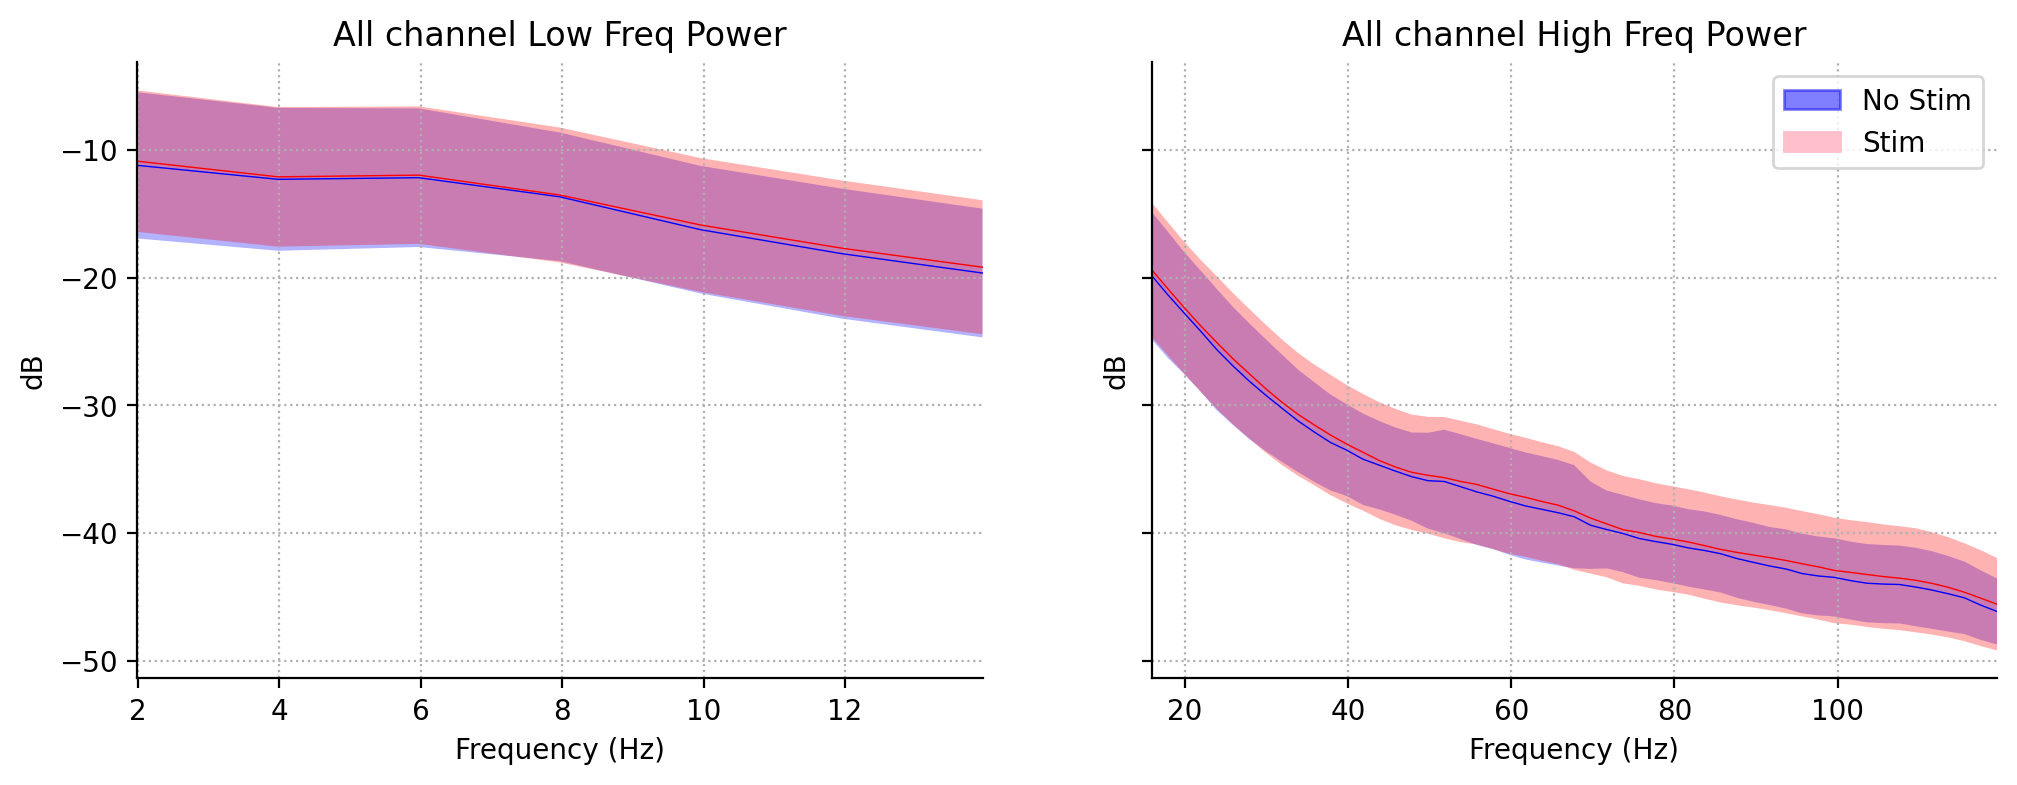

In [26]:
#### Sanity check code
StimEpoch = remembered_epoched_data['1']
NoStimEpoch = remembered_epoched_data['0']

###### NEW METHOD:

# Compute PSD using multitaper method
ns____power_low = NoStimEpoch.compute_psd(
    method='multitaper', fmin=1, fmax=15, tmin=0, tmax=0.5, bandwidth=12, adaptive=True)

# Compute PSD using multitaper method
stim___power_low = StimEpoch.compute_psd(
    method='multitaper', fmin=1, fmax=15, tmin=0, tmax=0.5, bandwidth=12, adaptive=True)

# Compute PSD using multitaper method
stim____power_high = StimEpoch.compute_psd(
    method='multitaper', fmin=15, fmax=120, tmin=0, tmax=0.5, bandwidth=20, adaptive=True)

# Compute PSD using multitaper method
ns____power_high = NoStimEpoch.compute_psd(
    method='multitaper', fmin=15, fmax=120, tmin=0, tmax=0.5, bandwidth=20, adaptive=True)
'''

###### OLD METHOD:
ns____power_low = NoStimEpoch.compute_psd(method = 'multitaper', fmin = 1, fmax = 120, tmin = 0, tmax = 0.5)
ns____power_high = NoStimEpoch.compute_psd(method = 'multitaper', fmin = 1, fmax = 120, tmin = 0, tmax = 0.5)
stim___power_low = StimEpoch.compute_psd(method = 'multitaper', fmin = 1, fmax = 120, tmin = 0, tmax = 0.5)
stim____power_high = StimEpoch.compute_psd(method = 'multitaper', fmin = 1, fmax = 120, tmin = 0, tmax = 0.5)
'''

# Figure params
plt.close()
fig, axes = plt.subplots(1,2, figsize = (12,4), sharey = True) #first two numbers represent the matrix of subfigures created, for example, 1,4, will create 4 subfigures in a row

# Plot PSDs for all channels
ns____power_low.plot(axes = axes[0], color = 'blue', average = True)
stim___power_low.plot(axes = axes[0], color = 'red',average = True)

# Plot PSDs for ROI channels
ns____power_high.plot(axes = axes[1], color = 'blue', average = True)
stim____power_high.plot(axes = axes[1], color = 'red',average = True)

# Clean-up Figures
#fig.suptitle('\n (First 500 ms after image onset)')
axes[0].set_title('All channel Low Freq Power')
axes[1].set_title('All channel High Freq Power')
axes[0].set_ylabel('dB')
axes[1].set_ylabel('dB')
axes[0].set_xlabel('Frequency (Hz)')
axes[1].set_xlabel('Frequency (Hz)')
sns.despine(top = True, right = True)

# Manually create legend with custom colored patches
legend_patches = [
    mpatches.Patch(color='blue', label='No Stim', alpha=.5),
    mpatches.Patch(color='pink', label='Stim')
]
axes[1].legend(handles=legend_patches, loc='upper right')
axes[0].legend().remove()# Remove legend from the first subplot

# Save
plt.show()

    Using multitaper spectrum estimation with 5 DPSS windows
    Using multitaper spectrum estimation with 9 DPSS windows
process_epoch_freqs_separately returning shape: (13, 127, 60), (60,)
    Using multitaper spectrum estimation with 5 DPSS windows
    Using multitaper spectrum estimation with 9 DPSS windows
process_epoch_freqs_separately returning shape: (26, 127, 60), (60,)
Running ROI Hipp ...
Creating Stim epochs for Hipp ...
    Using multitaper spectrum estimation with 5 DPSS windows
    Using multitaper spectrum estimation with 9 DPSS windows
process_epoch_freqs_separately returning shape: (13, 1, 60), (60,)
    Using multitaper spectrum estimation with 5 DPSS windows
    Using multitaper spectrum estimation with 9 DPSS windows
process_epoch_freqs_separately returning shape: (26, 1, 60), (60,)
Calculating Theta and Gamma differences ...
Generating 0-0.5 sec power minus -0.5-0 sec power ...
    Using multitaper spectrum estimation with 5 DPSS windows
    Using multitaper spect

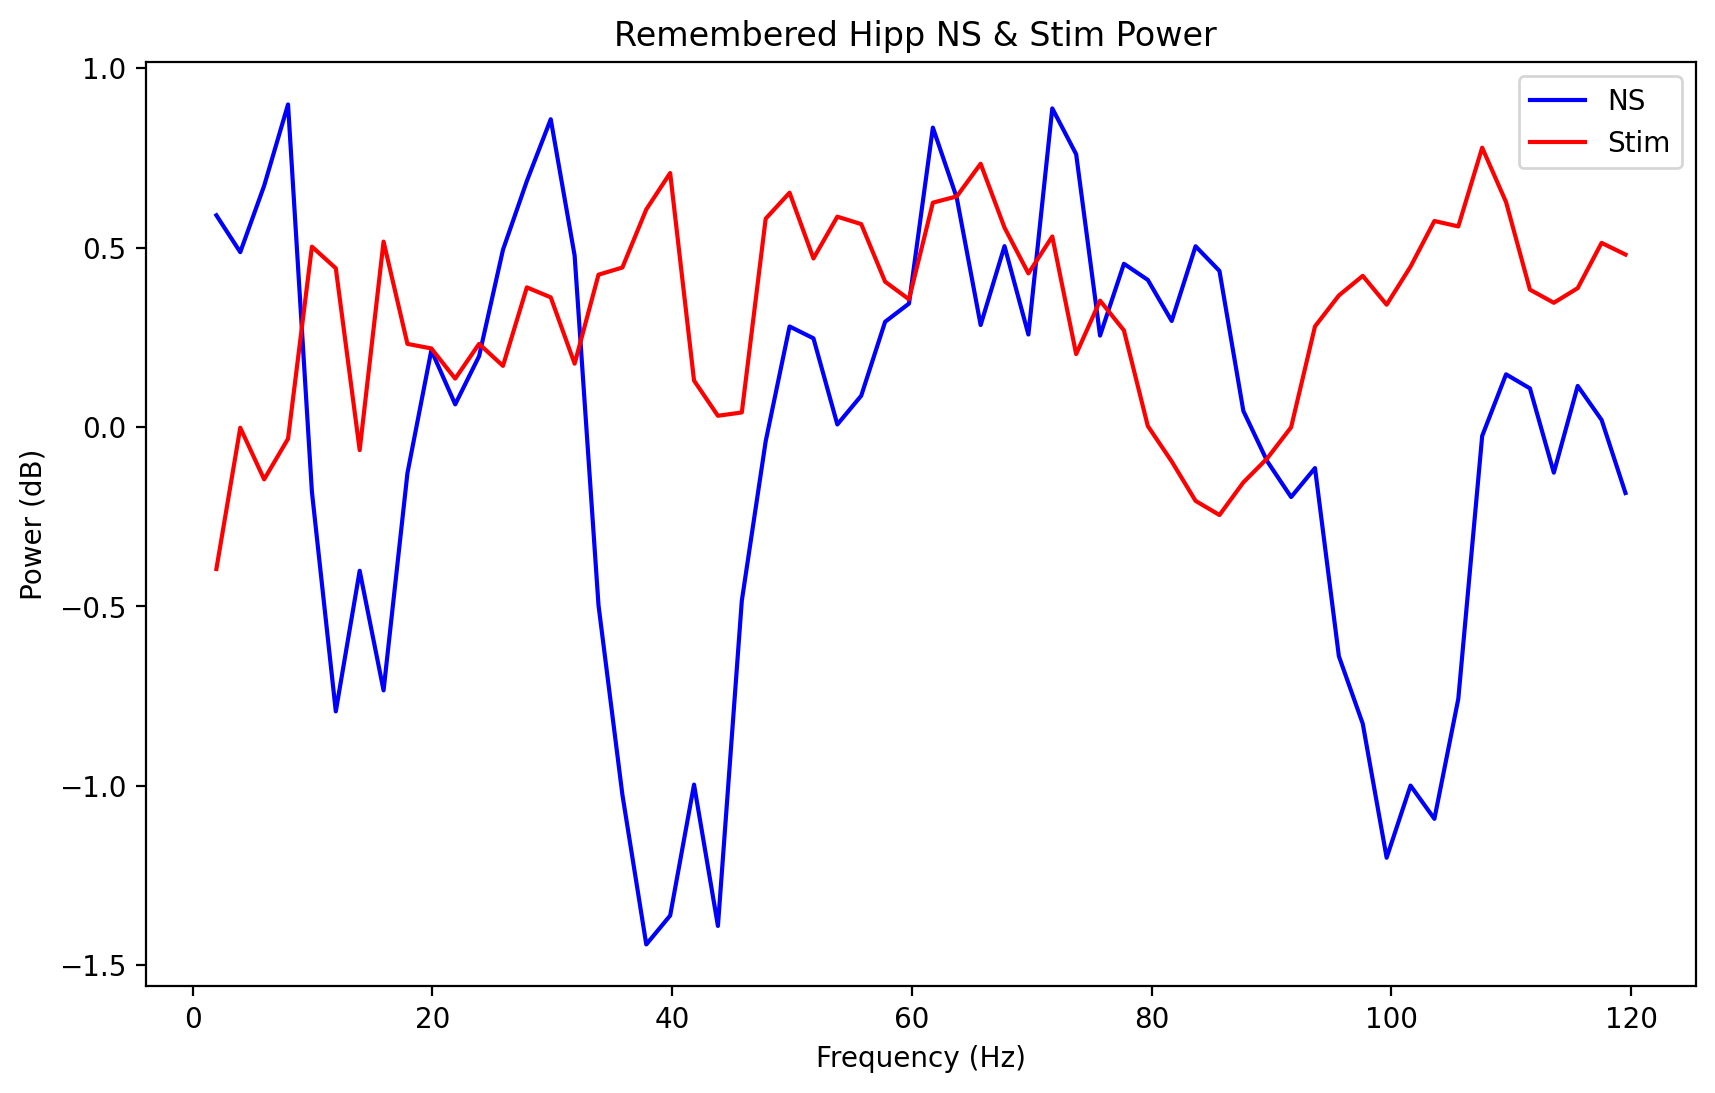

Plotting PSDs ...


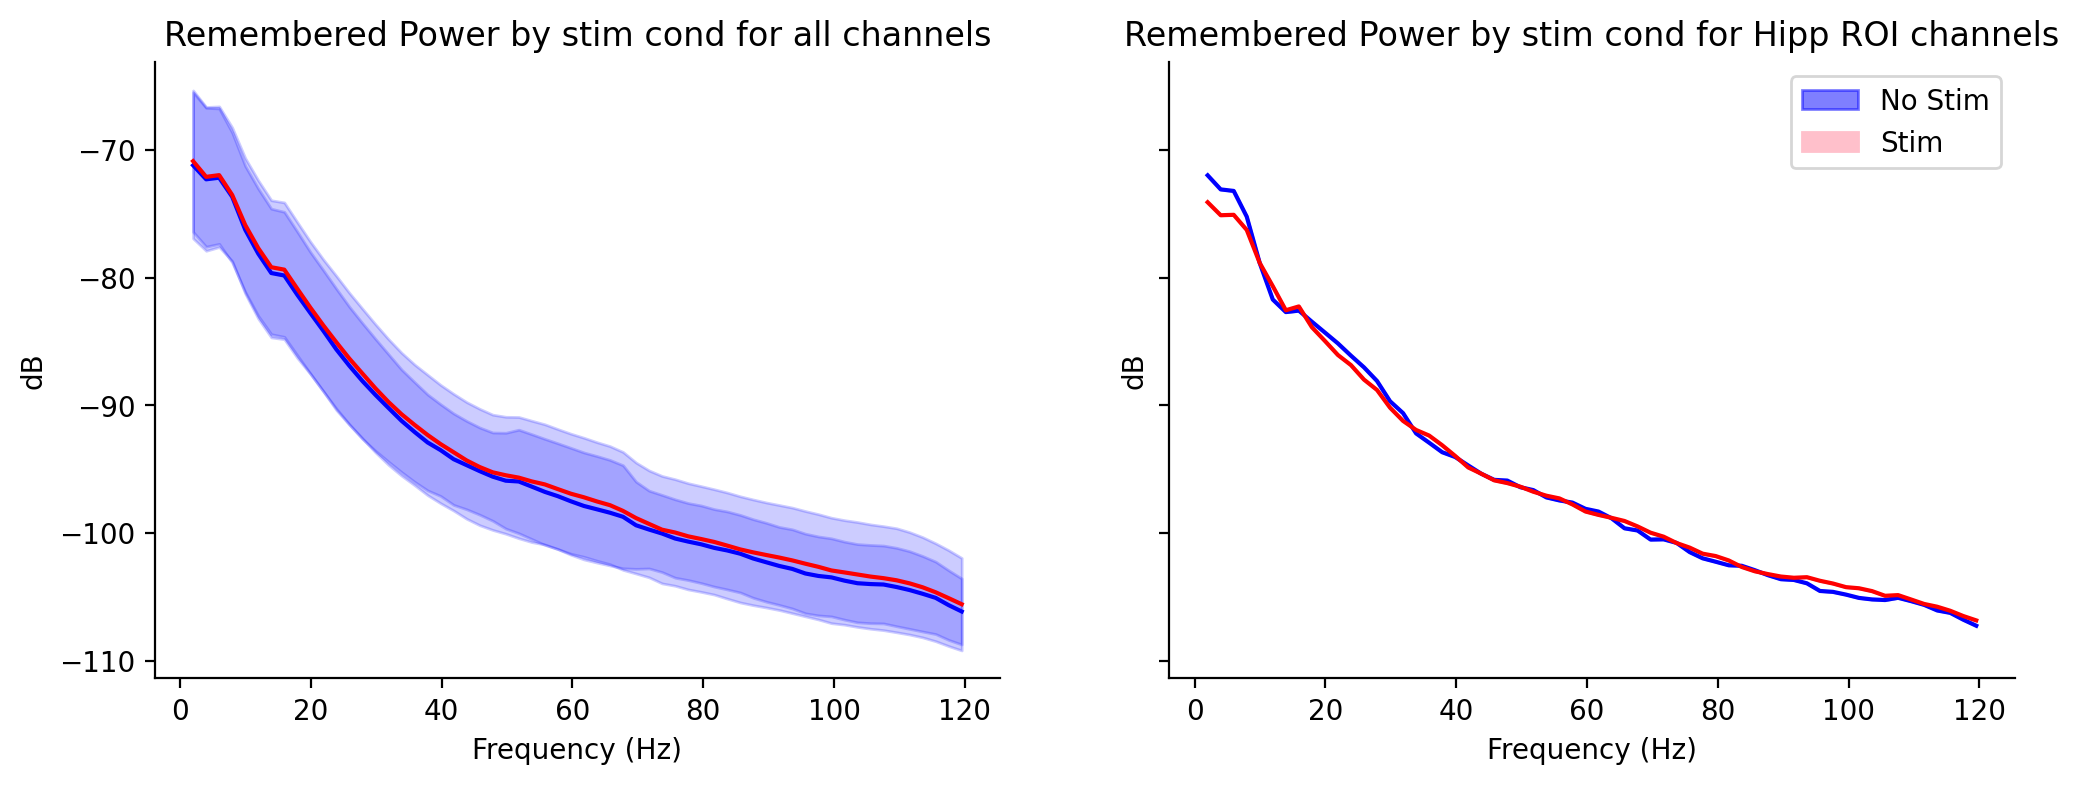

Running ROI BLA ...
Creating Stim epochs for BLA ...
    Using multitaper spectrum estimation with 5 DPSS windows
    Using multitaper spectrum estimation with 9 DPSS windows
process_epoch_freqs_separately returning shape: (13, 1, 60), (60,)
    Using multitaper spectrum estimation with 5 DPSS windows
    Using multitaper spectrum estimation with 9 DPSS windows
process_epoch_freqs_separately returning shape: (26, 1, 60), (60,)
Calculating Theta and Gamma differences ...
Generating 0-0.5 sec power minus -0.5-0 sec power ...
    Using multitaper spectrum estimation with 5 DPSS windows
    Using multitaper spectrum estimation with 9 DPSS windows
process_epoch_freqs_separately returning shape: (13, 1, 60), (60,)
    Using multitaper spectrum estimation with 5 DPSS windows
    Using multitaper spectrum estimation with 9 DPSS windows
process_epoch_freqs_separately returning shape: (26, 1, 60), (60,)
    Using multitaper spectrum estimation with 5 DPSS windows
    Using multitaper spectrum es

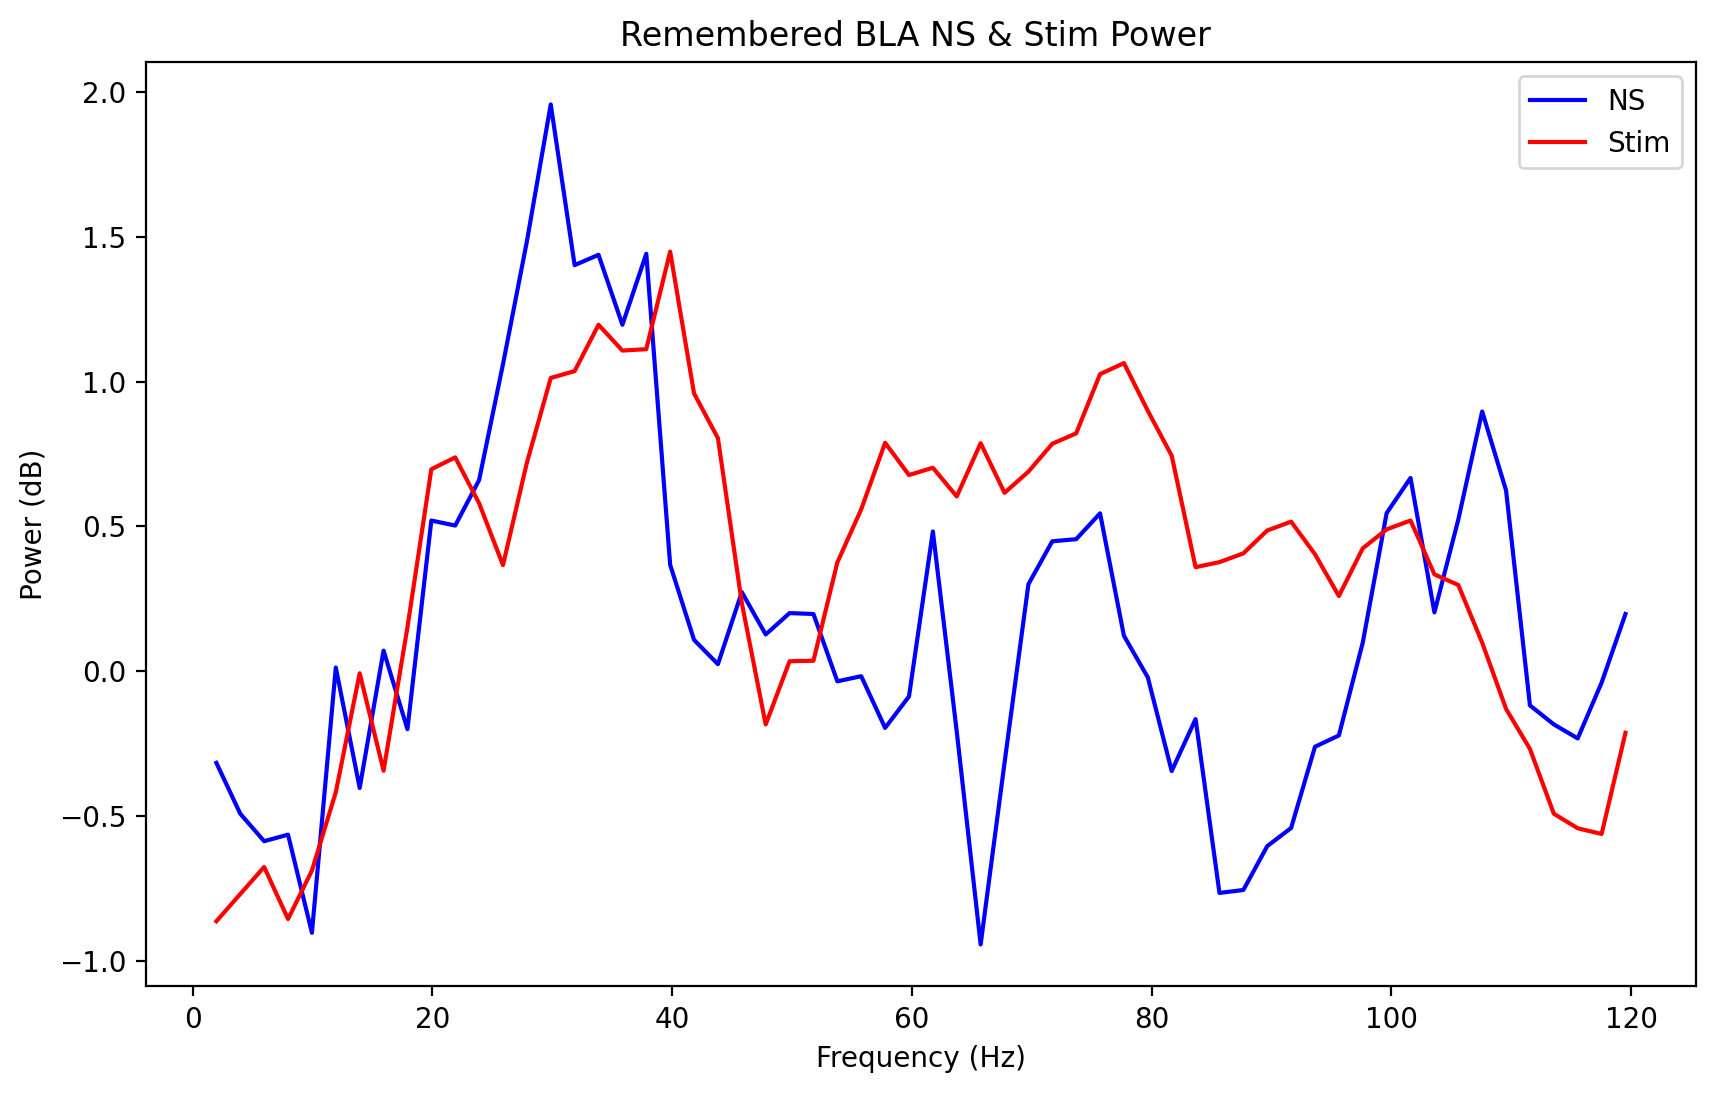

Plotting PSDs ...


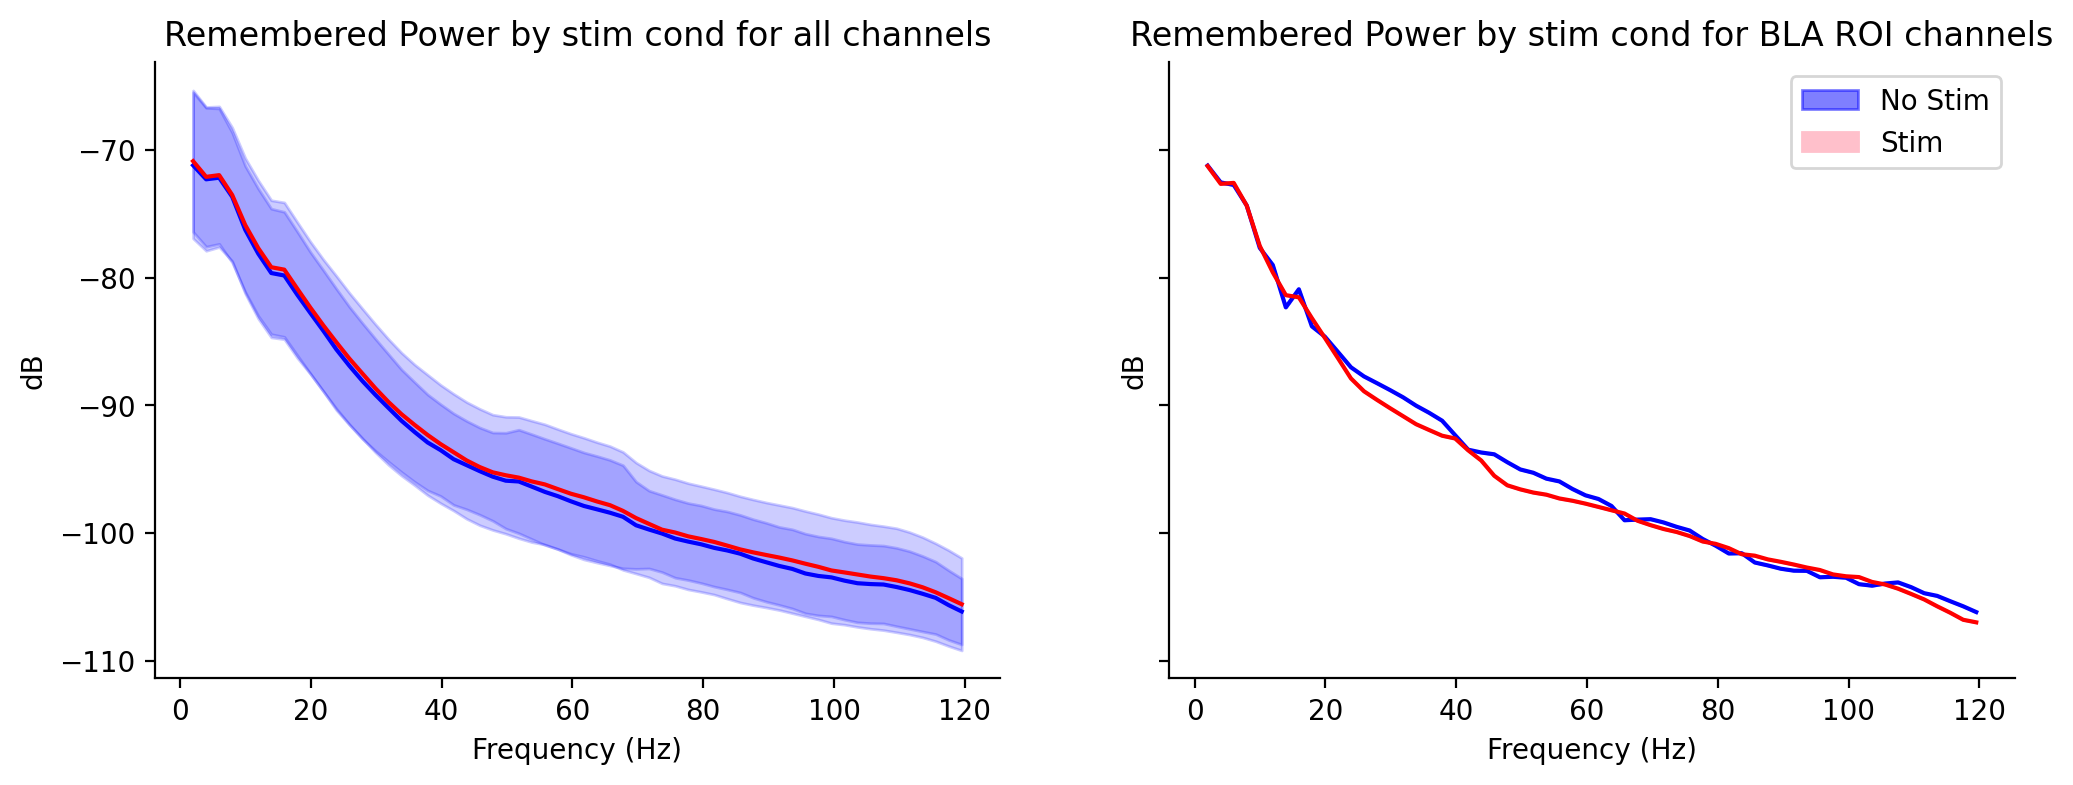

Running ROI MTL ...
Creating Stim epochs for MTL ...
    Using multitaper spectrum estimation with 5 DPSS windows
    Using multitaper spectrum estimation with 9 DPSS windows
process_epoch_freqs_separately returning shape: (13, 2, 60), (60,)
    Using multitaper spectrum estimation with 5 DPSS windows
    Using multitaper spectrum estimation with 9 DPSS windows
process_epoch_freqs_separately returning shape: (26, 2, 60), (60,)
Calculating Theta and Gamma differences ...
Generating 0-0.5 sec power minus -0.5-0 sec power ...
    Using multitaper spectrum estimation with 5 DPSS windows
    Using multitaper spectrum estimation with 9 DPSS windows
process_epoch_freqs_separately returning shape: (13, 2, 60), (60,)
    Using multitaper spectrum estimation with 5 DPSS windows
    Using multitaper spectrum estimation with 9 DPSS windows
process_epoch_freqs_separately returning shape: (26, 2, 60), (60,)
    Using multitaper spectrum estimation with 5 DPSS windows
    Using multitaper spectrum es

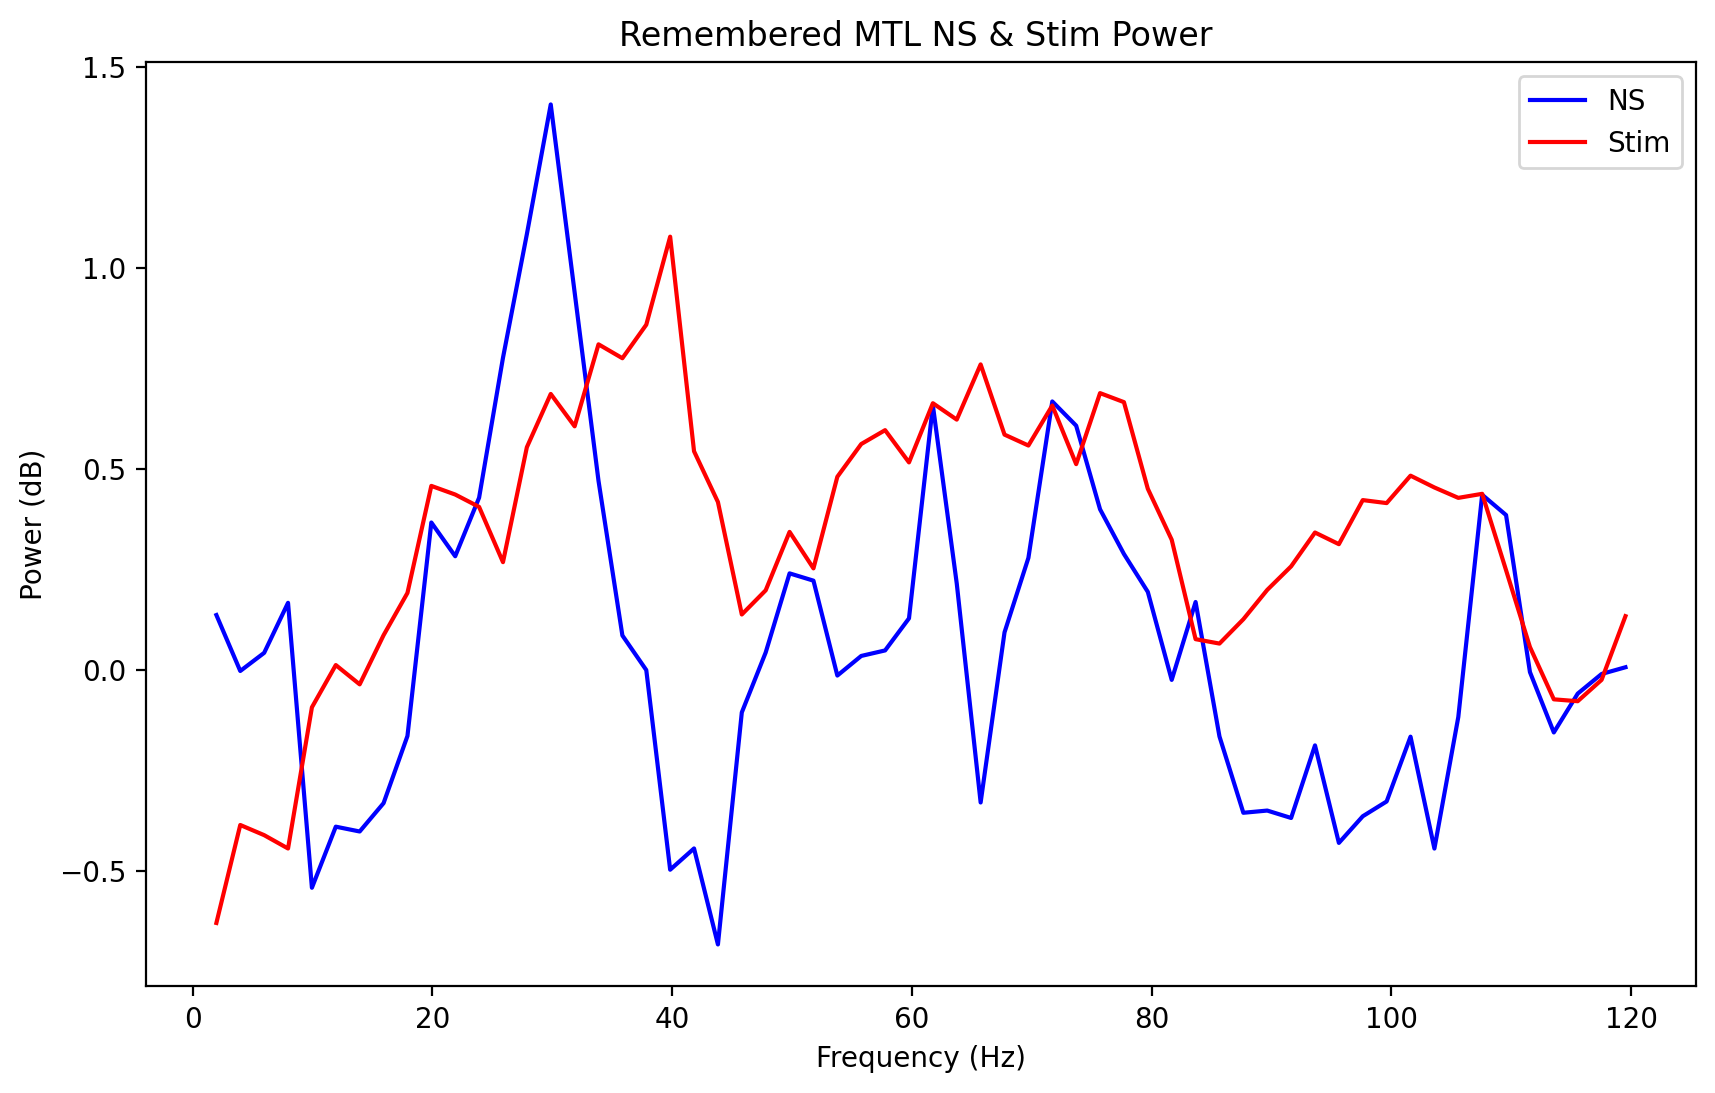

Plotting PSDs ...


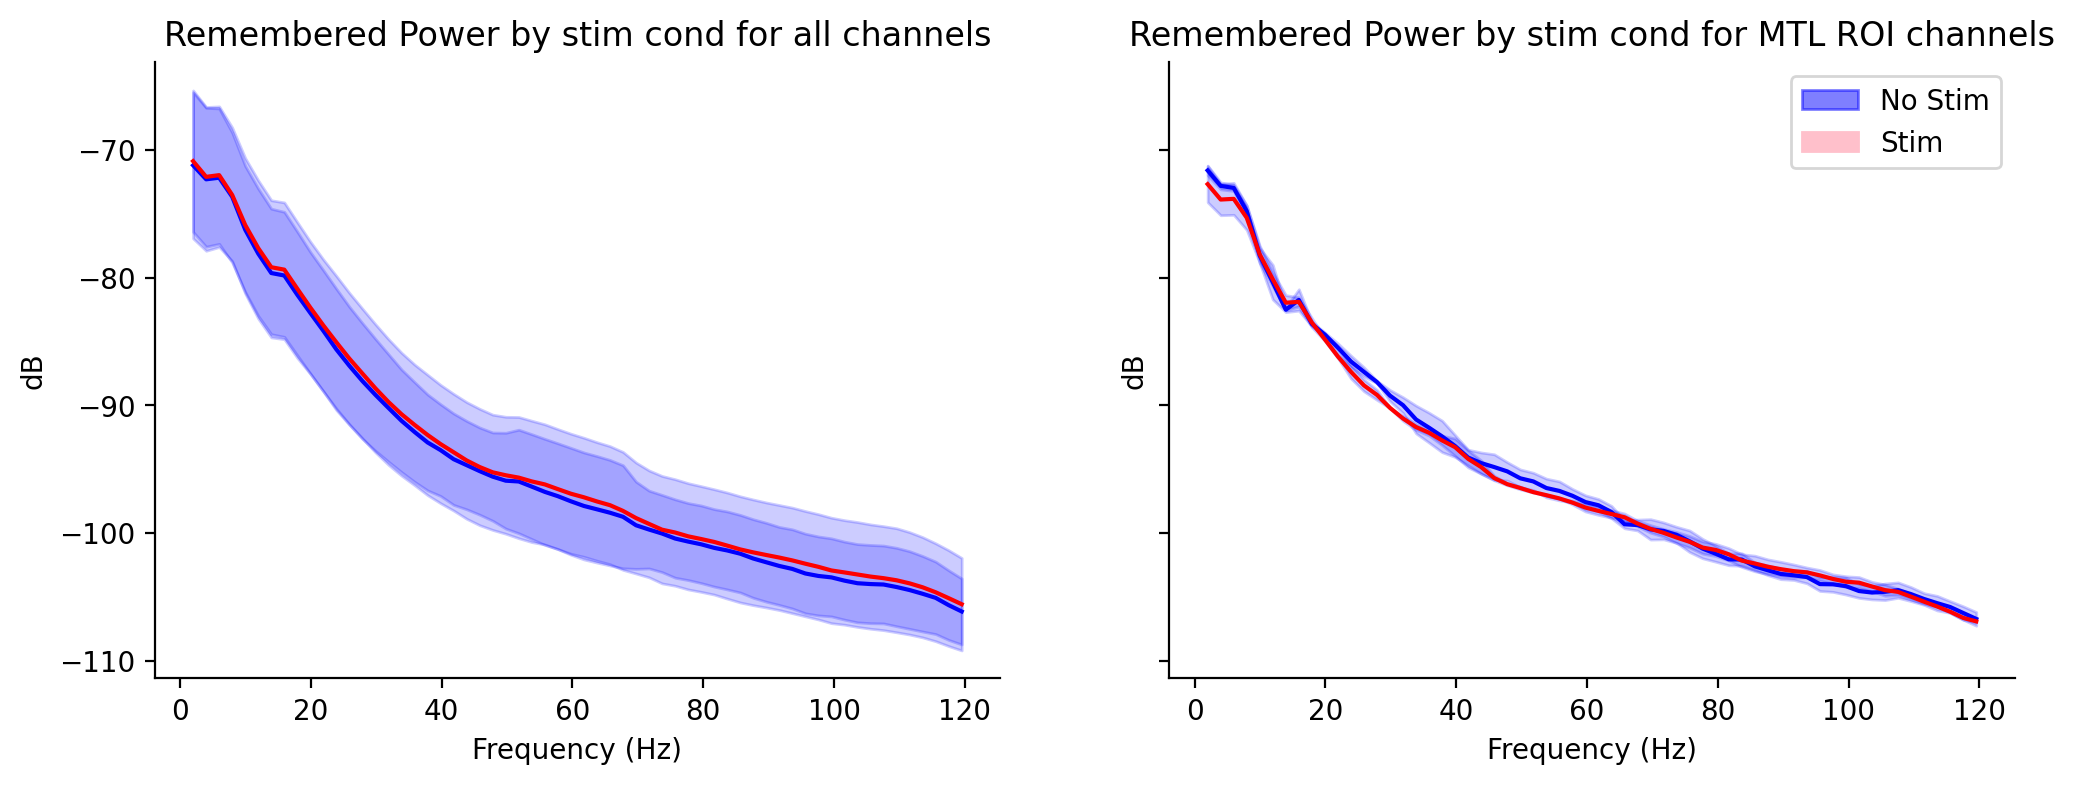

In [27]:
# Create stim/no-stim epochs
StimEpoch = remembered_epoched_data['1']
NoStimEpoch = remembered_epoched_data['0']

# Save epochs as numpy arrays
np.save(os.path.join(my_preprocessing_path, 'Remembered_NoStimEpoch.npy'), NoStimEpoch.get_data())
np.save(os.path.join(my_preprocessing_path, 'Remembered_OneStimEpoch.npy'), StimEpoch.get_data())

#Save in matlab
io.savemat(os.path.join(my_preprocessing_path, 'Remembered_NoStimEpoch.mat'), {'NoStimEpoch': NoStimEpoch.get_data()})
io.savemat(os.path.join(my_preprocessing_path, 'Remembered_OneStimEpoch.mat'), {'StimEpoch': StimEpoch.get_data()})

# Compute PSD
NS_power_np_arr, NS_freqs = process_epoch_freqs_separately(NoStimEpoch, tmin=0, tmax=0.5)
Stim_power_np_arr, Stim_freqs = process_epoch_freqs_separately(StimEpoch, tmin=0, tmax=0.5)


# For each ROI set, run the plots!
for roi_name, roi_channels in ROIs.items():
    # Skip if we dont use that ROI stuff
    if roi_channels == []:
        continue

    print(f"Running ROI {roi_name} ...")

    print(f"Creating Stim epochs for {roi_name} ...")
    # Create Avg Stim epochs
    stim_data = StimEpoch.get_data()

    # Compute Stim and No Stim PSDs for ROI channels
    NS_power_np_arr_roi, NS_freqs_roi = process_epoch_freqs_separately(NoStimEpoch.copy().pick(picks=roi_channels), tmin=0, tmax=0.5)
    Stim_power_np_arr_roi, Stim_freqs_roi = process_epoch_freqs_separately(StimEpoch.copy().pick(picks=roi_channels), tmin=0, tmax=0.5)

    # Average across epochs, then get the raw numpy array so we can save that and read into group analysis
    NS_power_numpy_arr = 10* np.log(np.mean(NS_power_np_arr_roi, axis=0))
    Stim_power_numpy_arr = 10* np.log(np.mean(Stim_power_np_arr_roi, axis=0))

    # Average across the channels
    NS_power_numpy_arr = NS_power_numpy_arr.mean(axis=0)
    Stim_power_numpy_arr = Stim_power_numpy_arr.mean(axis=0)
    AvgStim_power_numpy_arr = Stim_power_numpy_arr

    # Save the averaged power for this ROI so that we can use it in the group script
    np.save(os.path.join(my_preprocessing_path, f'ROI_{roi_name}_NS_power_remembered.npy'), NS_power_numpy_arr)
    np.save(os.path.join(my_preprocessing_path, f'ROI_{roi_name}_Stim_power_remembered.npy'), AvgStim_power_numpy_arr)

    print("Calculating Theta and Gamma differences ...")
    # Get freqs
    PSD_freqs = NS_freqs_roi

    # Save the avg power for this ROI into a numpy array
    thetaAvgStim = np.array(AvgStim_power_numpy_arr[(PSD_freqs >= 4) & (PSD_freqs <= 8)])
    thetaNoStim = np.array(NS_power_numpy_arr[(PSD_freqs >= 4) & (PSD_freqs <= 8)])
    thetaAvgDiff = (thetaAvgStim - thetaNoStim).mean()
    thetaStim = np.array(Stim_power_numpy_arr[(PSD_freqs >= 4) & (PSD_freqs <= 8)])
    thetaDiff = (thetaStim - thetaNoStim).mean()

    gammaAvgStim = np.array(AvgStim_power_numpy_arr[(PSD_freqs >= 30) & (PSD_freqs <= 55)])
    gammaNoStim = np.array(NS_power_numpy_arr[(PSD_freqs >= 30) & (PSD_freqs <= 55)])
    gammaAvgDiff = (gammaAvgStim - gammaNoStim).mean()
    gammaStim = np.array(Stim_power_numpy_arr[(PSD_freqs >= 30) & (PSD_freqs <= 55)])
    gammaDiff = (gammaStim - gammaNoStim).mean()

    np.save(os.path.join(my_preprocessing_path, f'ROI_{roi_name}_avg_vs_ns_power_theta_remembered.npy'), thetaAvgDiff)
    np.save(os.path.join(my_preprocessing_path, f'ROI_{roi_name}_stim_vs_ns_power_theta_remembered.npy'), thetaDiff)
    np.save(os.path.join(my_preprocessing_path, f'ROI_{roi_name}_avg_vs_ns_power_gamma_remembered.npy'), gammaAvgDiff)
    np.save(os.path.join(my_preprocessing_path, f'ROI_{roi_name}_stim_vs_ns_power_gamma_remembered.npy'), gammaDiff)

    print("Generating 0-0.5 sec power minus -0.5-0 sec power ...")
    # Generate power for -0.5 sec to 0 sec (baseline) and for 0 sec to 0.5 sec (analysis window)
    # Then subtract the two to get the difference. Average ThreeSec and OneSec
    # BASELINE
    NS_power_np_arr_roi_baseline, _ = process_epoch_freqs_separately(NoStimEpoch.copy().pick(picks=roi_channels), tmin=-0.5, tmax=0)
    NS_power_roi_baseline = np.log10(np.mean(NS_power_np_arr_roi_baseline, axis=0))*10
    Stim_power_np_arr_roi_baseline, _ = process_epoch_freqs_separately(StimEpoch.copy().pick(picks=roi_channels), tmin=-0.5, tmax=0)
    Stim_power_roi_baseline = np.log10(np.mean(Stim_power_np_arr_roi_baseline, axis=0))*10
  
    # ANALYSIS WINDOW
    NS_power_np_arr_roi_post, _ = process_epoch_freqs_separately(NoStimEpoch.copy().pick(picks=roi_channels), tmin=0, tmax=0.5)
    NS_power_roi_post = np.log10(np.mean(NS_power_np_arr_roi_post, axis=0))*10
    Stim_power_np_arr_roi_post, _ = process_epoch_freqs_separately(StimEpoch.copy().pick(picks=roi_channels), tmin=-0, tmax=0.5)
    Stim_power_roi_post = np.log10(np.mean(Stim_power_np_arr_roi_post, axis=0))*10

    # Average across channels
    NS_power_roi_baseline = NS_power_roi_baseline.mean(axis=0)
    Stim_power_roi_baseline = Stim_power_roi_baseline.mean(axis=0)

    NS_power_roi_post = NS_power_roi_post.mean(axis=0)
    Stim_power_roi_post = Stim_power_roi_post.mean(axis=0)

    # Average the roi post (0 -> 0.5 sec)
    AvgStim_power_roi_baseline = Stim_power_roi_baseline
    AvgStim_power_roi_post = Stim_power_roi_post

    # Subtract the baseline from the post
    NS_power_post_minus_baseline = NS_power_roi_post - NS_power_roi_baseline
    AvgStim_power_post_minus_baseline = AvgStim_power_roi_post - AvgStim_power_roi_baseline
    Stim_power_post_minus_baseline = Stim_power_roi_post - Stim_power_roi_baseline


    # Save the numpy arrays
    np.save(os.path.join(my_preprocessing_path, f'ROI_{roi_name}_NS_power_post_minus_baseline_remembered.npy'), NS_power_post_minus_baseline)
    np.save(os.path.join(my_preprocessing_path, f'ROI_{roi_name}_Stim_power_post_minus_baseline_remembered.npy'), AvgStim_power_post_minus_baseline)

    # Create a range for the x-axis
    x = PSD_freqs
    # Plot the lines
    plt.close()
    plt.figure(figsize=(10, 6))
    plt.plot(x, NS_power_post_minus_baseline.flatten(), label='NS', color='blue', linestyle='-')
    plt.plot(x, AvgStim_power_post_minus_baseline.flatten(), label='Stim', color='red', linestyle='-')

    # Add titles and labels
    plt.title(f'Remembered {roi_name} NS & Stim Power ')
    #plt.ylim([-1,1])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power (dB)')
    plt.legend()

    # Show the plot
    plt.show()

    print("Plotting PSDs ...")

    # Power Spectral Density Params (PSD)
    pad = 0.1

    # Figure params
    plt.close()
    fig, axes = plt.subplots(1,2, figsize = (12,4), sharey = True) #first two numbers represent the matrix of subfigures created, for example, 1,4, will create 4 subfigures in a row

    ## Plot PSDs for all channels
    # Avg across epochs. Log10 to make it decibels
    avg_ns_power_np_arr = np.log10(np.mean(NS_power_np_arr, axis=0)) * 10
    avg_stim_power_np_arr = np.log10(np.mean(Stim_power_np_arr, axis=0)) * 10

    # Calculate the mean and standard deviation across samples
    ns_power_mean = np.mean(avg_ns_power_np_arr, axis=0)
    ns_power_std = np.std(avg_ns_power_np_arr, axis=0)
    stim_power_mean = np.mean(avg_stim_power_np_arr, axis=0)
    stim_power_std = np.std(avg_stim_power_np_arr, axis=0)

    axes[0].plot(NS_freqs, ns_power_mean, label='NS Mean', color='blue')
    axes[0].fill_between(NS_freqs, ns_power_mean - ns_power_std, ns_power_mean + ns_power_std, color='b', alpha=0.2, label='NS SD')
    axes[0].plot(Stim_freqs, stim_power_mean, label='Stim Mean', color='red')
    axes[0].fill_between(Stim_freqs, stim_power_mean - stim_power_std, stim_power_mean + stim_power_std, color='b', alpha=0.2, label='Stim SD')

    # Plot PSDs for ROI channels
    avg_ns_power_np_arr_roi = np.log10(np.mean(NS_power_np_arr_roi, axis=0)) * 10
    avg_stim_power_np_arr_roi = np.log10(np.mean(Stim_power_np_arr_roi, axis=0)) * 10
    
    # Calculate the mean and standard deviation across samples
    ns_power_mean_roi = np.mean(avg_ns_power_np_arr_roi, axis=0)
    ns_power_std_roi = np.std(avg_ns_power_np_arr_roi, axis=0)
    stim_power_mean_roi = np.mean(avg_stim_power_np_arr_roi, axis=0)
    stim_power_std_roi = np.std(avg_stim_power_np_arr_roi, axis=0)

    axes[1].plot(NS_freqs_roi, ns_power_mean_roi, label='NS Mean', color='blue')
    axes[1].fill_between(NS_freqs_roi, ns_power_mean_roi - ns_power_std_roi, ns_power_mean_roi + ns_power_std_roi, color='b', alpha=0.2, label='NS SD')
    axes[1].plot(Stim_freqs_roi, stim_power_mean_roi, label='Stim Mean', color='red')
    axes[1].fill_between(Stim_freqs_roi, stim_power_mean_roi - stim_power_std_roi, stim_power_mean_roi + stim_power_std_roi, color='b', alpha=0.2, label='Stim SD')

    # Clean-up Figures
    #fig.suptitle('\n (First 500 ms after image onset)')
    axes[0].set_title('Remembered Power by stim cond for all channels')
    axes[1].set_title(f'Remembered Power by stim cond for {roi_name} ROI channels')
    axes[0].set_ylabel('dB')
    axes[1].set_ylabel('dB')
    axes[0].set_xlabel('Frequency (Hz)')
    axes[1].set_xlabel('Frequency (Hz)')
    sns.despine(top = True, right = True)

    # Manually create legend with custom colored patches
    legend_patches = [
        mpatches.Patch(color='blue', label='No Stim', alpha=.5),
        mpatches.Patch(color='pink', label='Stim')
    ]
    axes[1].legend(handles=legend_patches, loc='upper right')
    axes[0].legend().remove()# Remove legend from the first subplot

    # Save
    plt.savefig(os.path.join(savepath, f'Remembered_PowerSpectra-{roi_name}.png'), dpi = 1200, bbox_inches = 'tight')
    plt.show()

### 3.2 Stim Spectrograms

In [28]:
def plot_Spectrogram(TFR, chan, stimcond):
    '''
    Plot spectrogram from the mne.TFR object
    
    Arguments:
        TFR: mne.TFR object
        chan: channel index to plot (int)
        stimcond: adding stim condition to plot name
    
    Returns:
        None
    '''
    
    # Fig params
    fig, ax = plt.subplots(1,1, figsize = (10,4))
    vmin, vmax = -5.0, 5.0  # Define our color limits.
    cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS
    baseline = (-0.5, 0)  # Define our baseline period

    # Plot spectrogram (4-100 Hz, -200ms-700ms, log z-scored against baseline)
    TFR.plot(picks = [chan], baseline = baseline, mode = 'zlogratio', fmin = 1, fmax = 100, tmin = -0.2, tmax = 0.7, vmin = vmin, vmax = vmax, cmap = 'coolwarm', show = False, axes = ax, verbose = False)

    # Figure aeshetics
    ch_label = TFR.ch_names[chan]
    ax.axvline(x = 0, color = 'k', lw = 1, linestyle = '--')
    ax.axvline(x = 0.5, color = 'k', lw = 1, linestyle = '--')
    ax.axvspan(xmin = 0, xmax = 0.5, color = 'grey', alpha = 0.25)
    ax.set_yticks([5, 10, 30, 50, 70, 100], ['5', '10', '30', '50', '70', '100'], fontsize = 'small')
    ax.set_xticks([-0.2, 0, 0.5, 0.7], ['-0.2', '0', '0.5', '0.7'], fontsize = 'small')
    ax.set_xlabel('Time (s)', fontsize = 'medium')
    ax.set_ylabel('Frequency (Hz)', fontsize = 'medium')
    ax.set_title('Remembered '+ ROI_name + ' ' + ch_label + ' ' + stimcond, fontsize = 'large')
    plt.tight_layout()

    # Colorbar aesthetics
    cb = ax.collections[0].colorbar
    cb.set_ticks(ticks = [-4, -2, 0, 2, 4], labels = ['-4', '-2', '0', '2', '4'], fontsize = 'small')
    cb.set_label('$\it{z}$ (log pwr.)', fontsize = 'small')

    # Save
    plt.savefig(os.path.join(specPath,'Remembered_'+ ROI_name + '_' + ch_label + stimcond + '_Stim_Spectrogram.png'), dpi = 1500, bbox_inches = 'tight')
    plt.show()

<>:38: SyntaxWarning: invalid escape sequence '\i'
<>:38: SyntaxWarning: invalid escape sequence '\i'
/var/folders/4p/wvr1dn0j59d5sdhhr_8b001c0000gn/T/ipykernel_19625/3516309262.py:38: SyntaxWarning: invalid escape sequence '\i'
  cb.set_label('$\it{z}$ (log pwr.)', fontsize = 'small')


### Run individual spectograms

NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
==== Generating Spectrograms for Stim in Hipp ROIs


/var/folders/4p/wvr1dn0j59d5sdhhr_8b001c0000gn/T/ipykernel_19625/3516309262.py:21: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  TFR.plot(picks = [chan], baseline = baseline, mode = 'zlogratio', fmin = 1, fmax = 100, tmin = -0.2, tmax = 0.7, vmin = vmin, vmax = vmax, cmap = 'coolwarm', show = False, axes = ax, verbose = False)


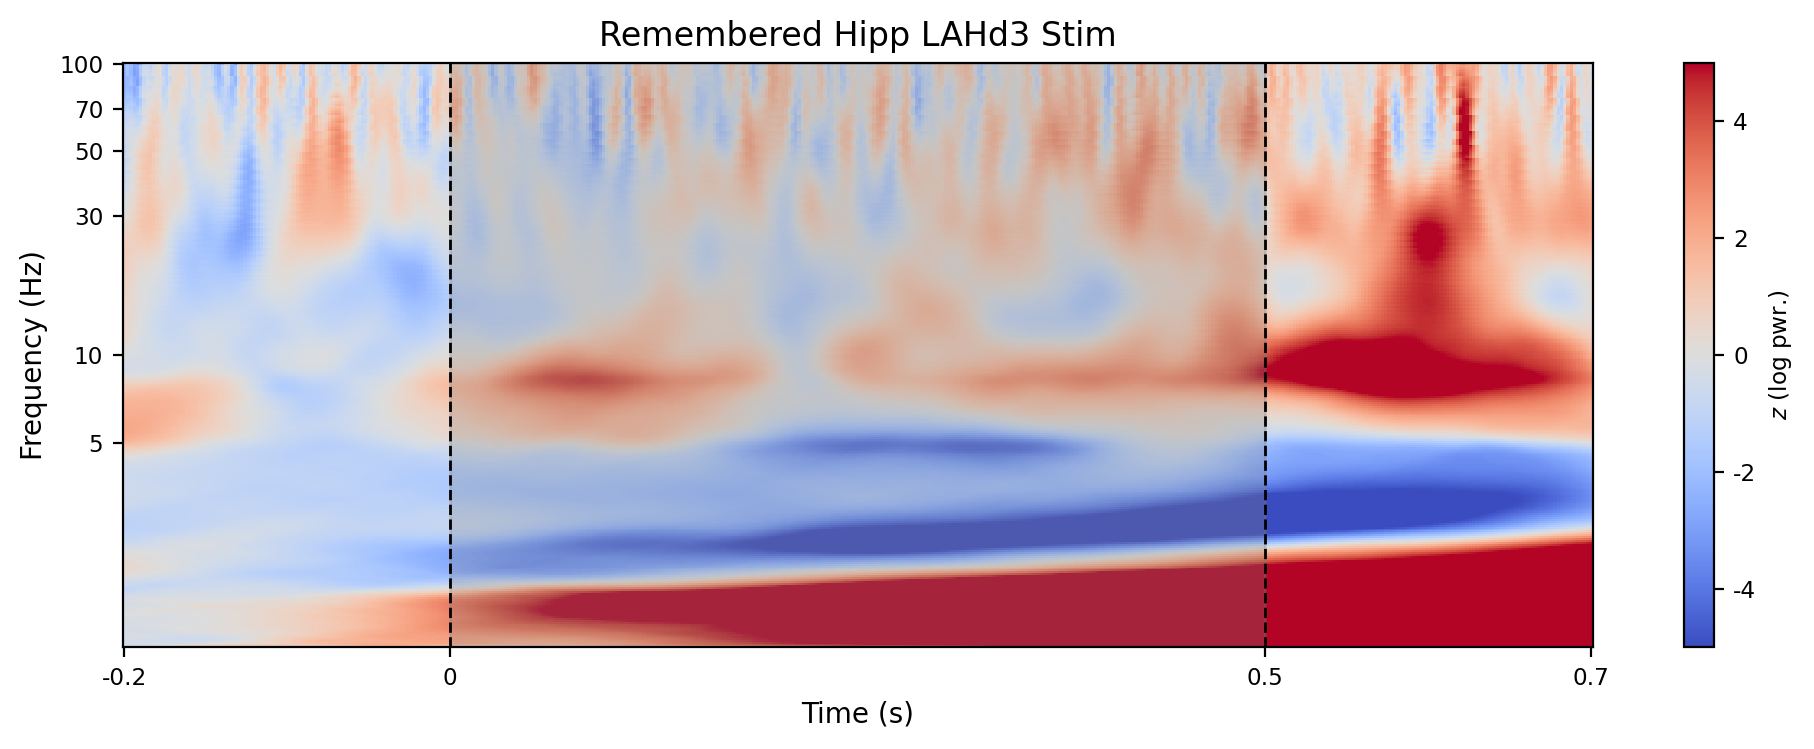

==== Generating Spectrograms for Stim in BLA ROIs


/var/folders/4p/wvr1dn0j59d5sdhhr_8b001c0000gn/T/ipykernel_19625/3516309262.py:21: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  TFR.plot(picks = [chan], baseline = baseline, mode = 'zlogratio', fmin = 1, fmax = 100, tmin = -0.2, tmax = 0.7, vmin = vmin, vmax = vmax, cmap = 'coolwarm', show = False, axes = ax, verbose = False)


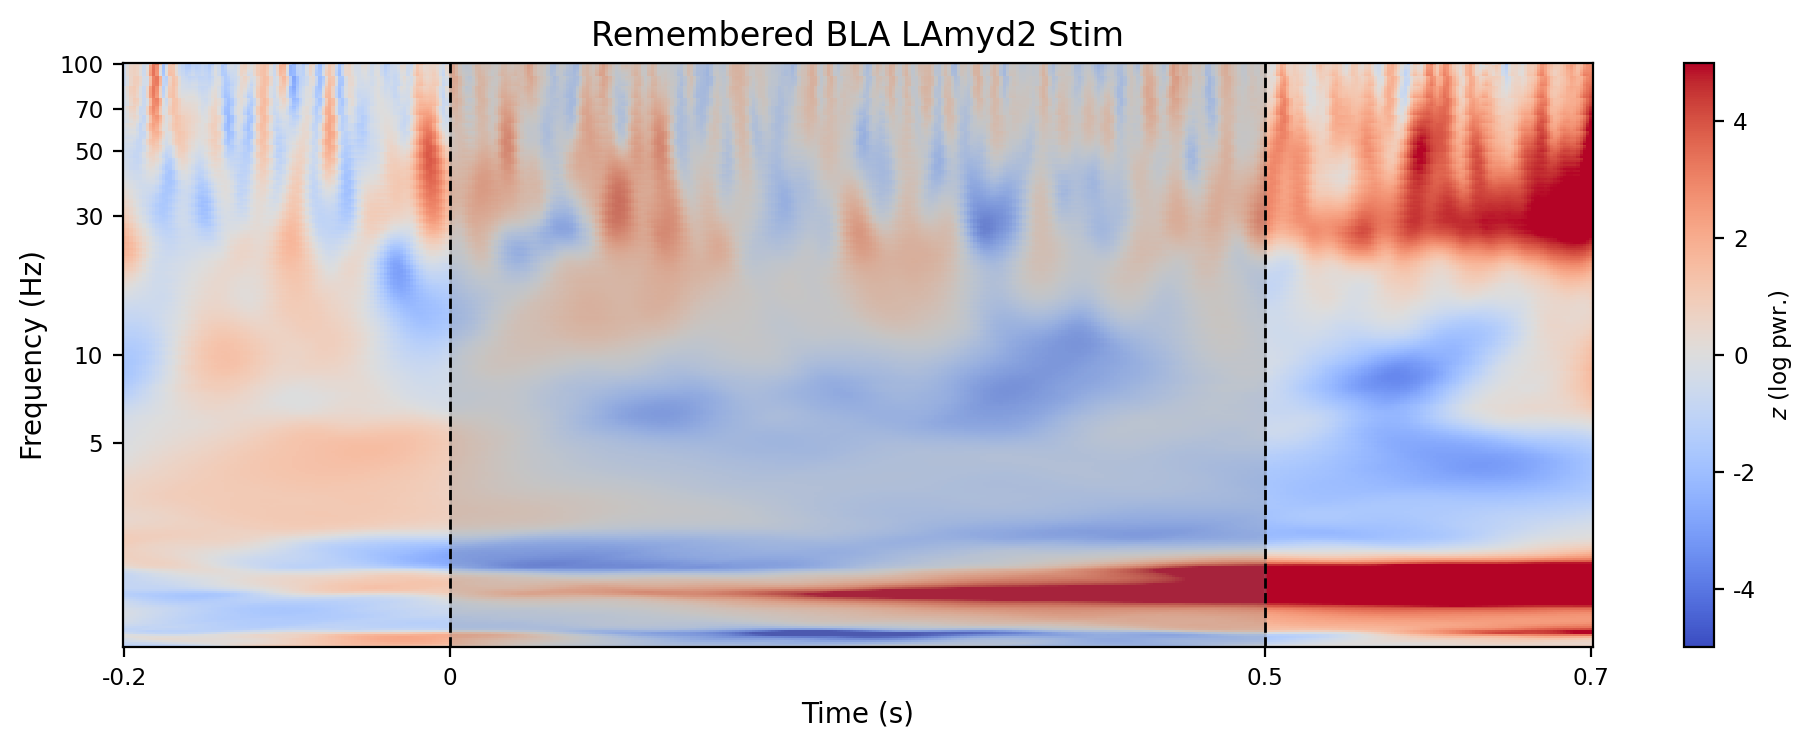

NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
==== Generating Spectrograms for NoStim in Hipp ROIs


/var/folders/4p/wvr1dn0j59d5sdhhr_8b001c0000gn/T/ipykernel_19625/3516309262.py:21: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  TFR.plot(picks = [chan], baseline = baseline, mode = 'zlogratio', fmin = 1, fmax = 100, tmin = -0.2, tmax = 0.7, vmin = vmin, vmax = vmax, cmap = 'coolwarm', show = False, axes = ax, verbose = False)


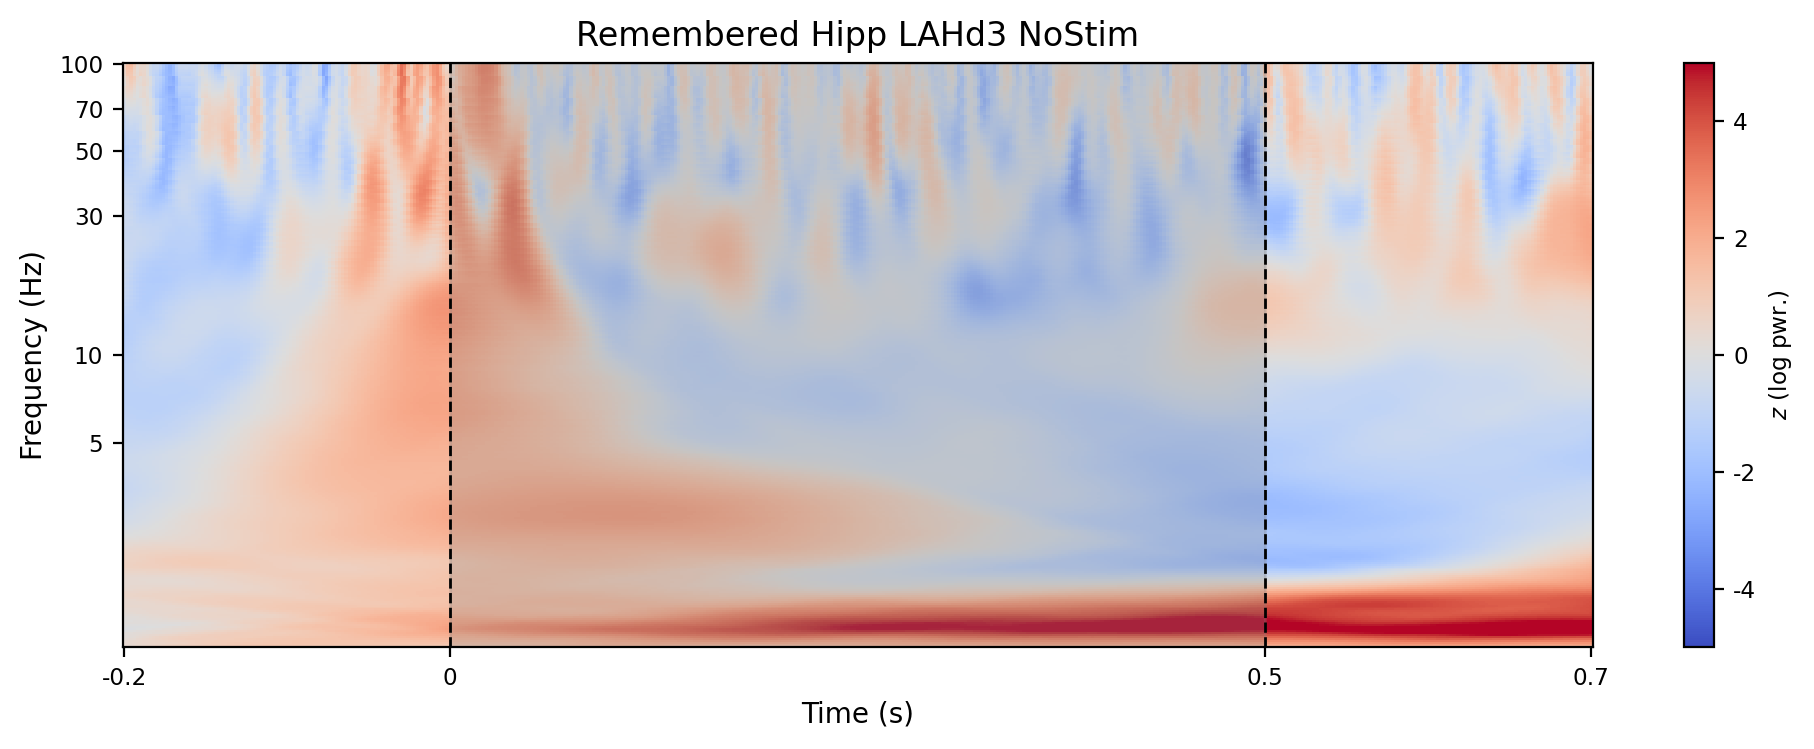

==== Generating Spectrograms for NoStim in BLA ROIs


/var/folders/4p/wvr1dn0j59d5sdhhr_8b001c0000gn/T/ipykernel_19625/3516309262.py:21: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  TFR.plot(picks = [chan], baseline = baseline, mode = 'zlogratio', fmin = 1, fmax = 100, tmin = -0.2, tmax = 0.7, vmin = vmin, vmax = vmax, cmap = 'coolwarm', show = False, axes = ax, verbose = False)


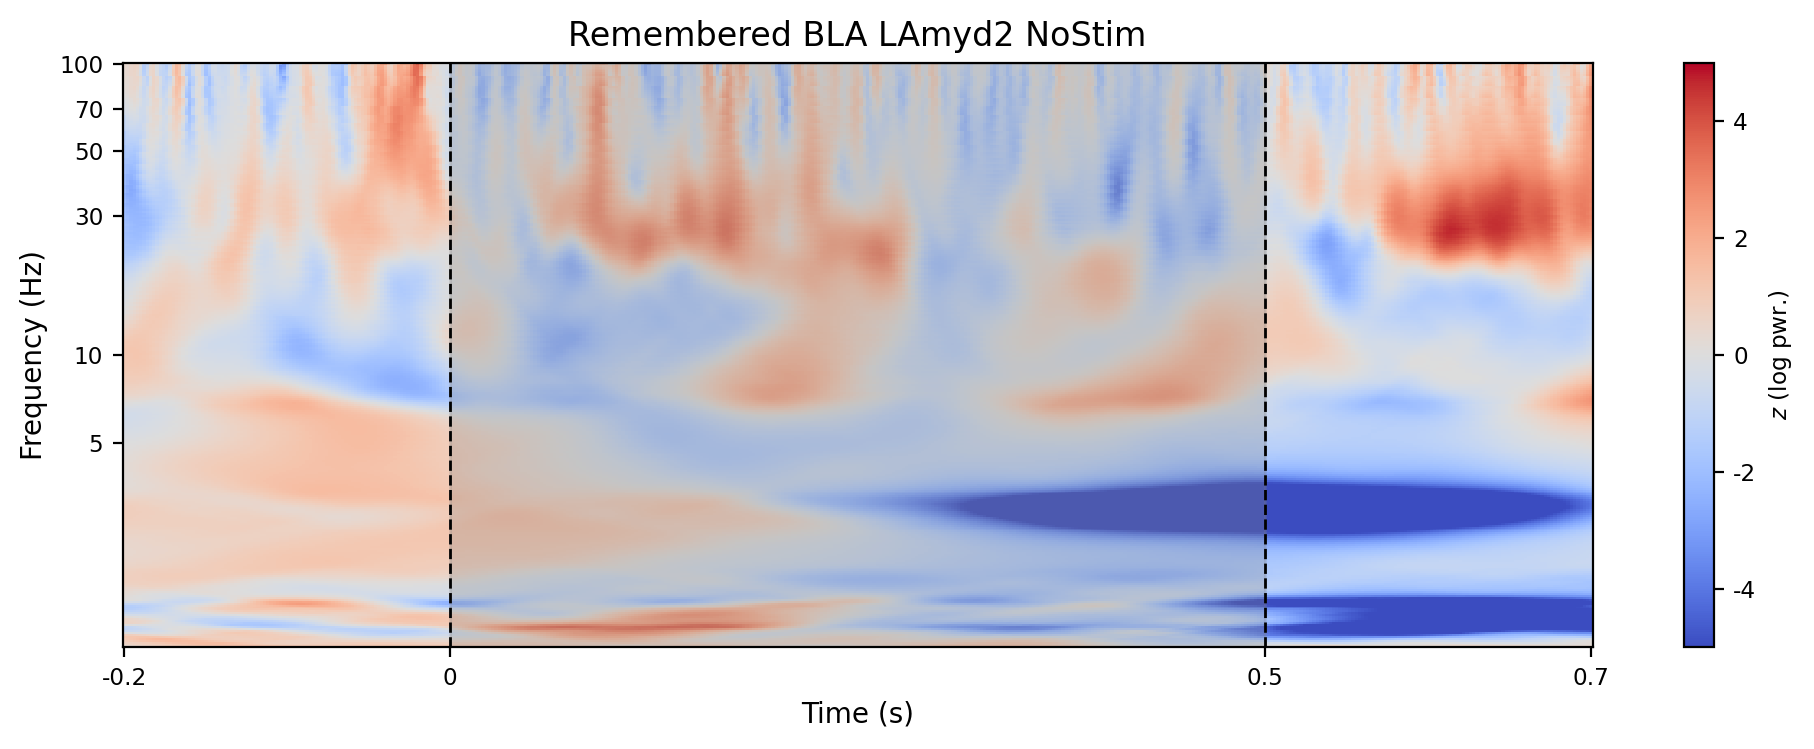

In [29]:
# Create Spectrogram folder if it doesn't exist
specPath = os.path.join(savepath, 'Spectrograms')
if not os.path.exists(specPath):
     os.mkdir(specPath)

stimtype = {
     'Stim' : StimEpoch.copy(),
     'NoStim' : NoStimEpoch.copy(),
}

#specFreqs = np.logspace(np.log10(1), np.log10(150), 300) #justin's freq range, but i have less data in each epoch so i need a shorter f range
specFreqs = np.logspace(np.log10(1), np.log10(100), 300)

for stim, epoch in stimtype.items():
    stimTFR = tfr_multitaper(epoch, freqs = specFreqs, n_cycles = 2, time_bandwidth = 2, return_itc = False, average = True, n_jobs = -1, verbose = False)

    #loop though the ROIs that are not empty
    for ROI_name, ROI_channels in ROIs.items():
        if not ROI_channels or ROI_name == 'MTL':
            continue
        print(f"==== Generating Spectrograms for {stim} in {ROI_name} ROIs")

        # Find indices for the ROI channels
        ROI_indices = [stimTFR.ch_names.index(ch) for ch in ROI_channels if ch in stimTFR.ch_names]

        # Generate spectrograms for each ROI channel
        for idx in ROI_indices:
            plot_Spectrogram(stimTFR, idx, stim)
        plt.close()



## Spectogram difference plots between stim and no stim

In [30]:
def plot_DiffSpectrogram(diff_StimTFR, chan_idx, ROI_name):
    '''
    Plot difference spectrograms from the mne.TFR objects
    
    Arguments:
        diff_OneStimTFR: mne.TFR object for NoStim vs OneStim condition
        diff_ThreeStimTFR: mne.TFR object for NoStim vs ThreeStim condition
        chan_idx: channel index to plot (int)
        ROI_name: name of the region of interest (str)
    
    Returns:
        None
    '''
    # Fig params
    fig, ax = plt.subplots(figsize=(20, 4))
    vmin, vmax = None, None  # Define our color limits.
    baseline = None

    cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

    # Plot NoStim vs OneStim difference spectrogram
    diff_StimTFR.plot(picks=chan_idx, baseline=baseline, mode='zlogratio', fmin=1, fmax=100, tmin=-0.2, tmax=0.7, vmin=vmin, vmax=vmax, cmap='coolwarm', show=False, axes=ax, verbose=False)
   
    ax.set_title(f'Remembered {ROI_name} {diff_StimTFR.ch_names[chan_idx]} NoStim vs Stim', fontsize='large')
    ax.axvline(x=0, color='k', lw=1, linestyle='--')
    ax.axvline(x=0.5, color='k', lw=1, linestyle='--')
    ax.axvspan(xmin=0, xmax=0.5, color='grey', alpha=0.25)
    ax.set_yticks([5, 10, 30, 50, 70, 100], ['5', '10', '30', '50', '70', '100'], fontsize='small')
    ax.set_xticks([-0.2, 0, 0.5, 0.7], ['-0.2', '0', '0.5', '0.7'], fontsize='small')
    ax.set_xlabel('Time (s)', fontsize='medium')
    ax.set_ylabel('Frequency (Hz)', fontsize='medium')

    plt.tight_layout()

    # Save
    plt.savefig(os.path.join(specPath, f'{ROI_name}_{diff_StimTFR.ch_names[chan_idx]}_Diff_Spectrogram_Remembered.png'), dpi=1500, bbox_inches='tight')
    plt.show()



NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
<class 'mne.time_frequency.tfr.AverageTFR'>
==== Generating Spectrograms for NoStim in Hipp ROIs


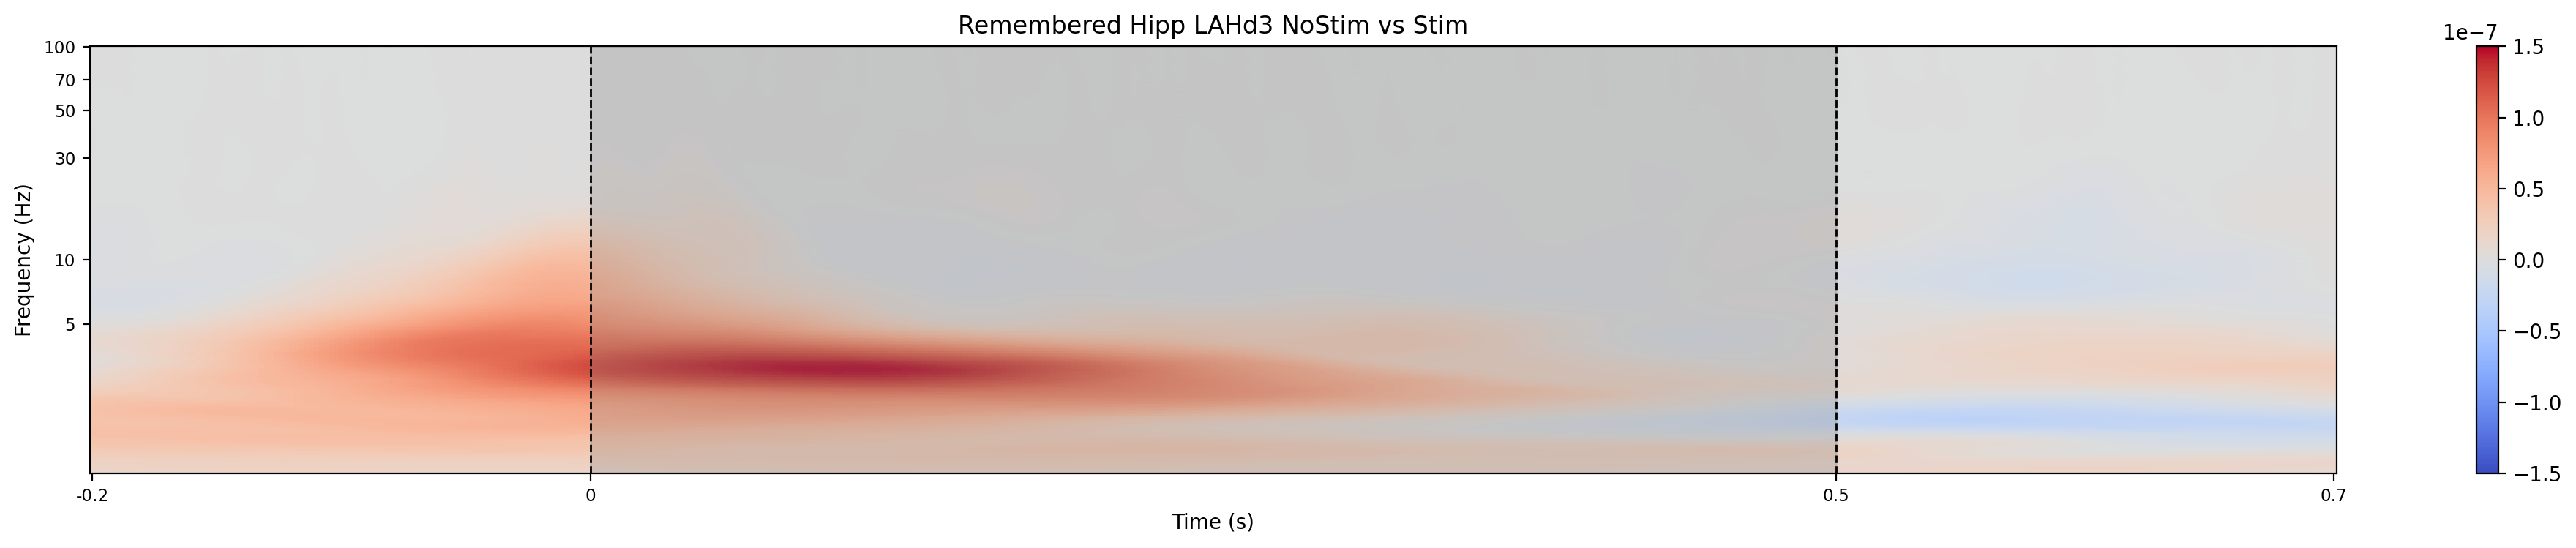

==== Generating Spectrograms for NoStim in BLA ROIs


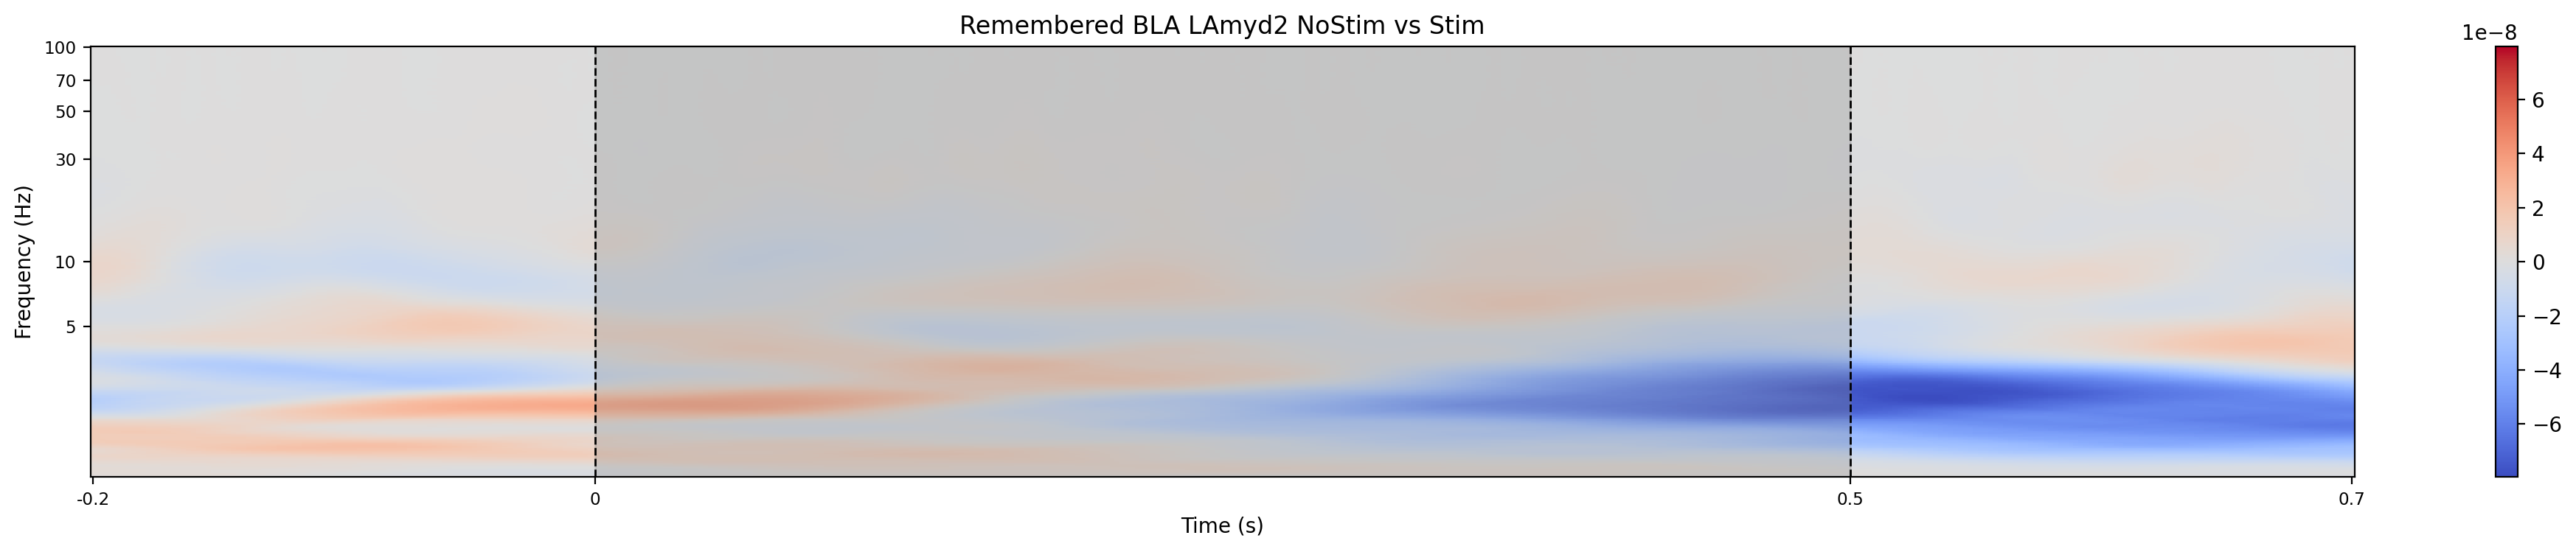

In [31]:
# Create Spectrogram folder if it doesn't exist
specPath = os.path.join(savepath, 'Spectrograms')
if not os.path.exists(specPath):
    os.mkdir(specPath)

# Example frequency range and epochs for NoStim, OneStim, and ThreeStim conditions
specFreqs = np.logspace(np.log10(1), np.log10(100), 300)

# Replace these with actual epoch data for your conditions
stimSpecEpoch_NoStim = NoStimEpoch.copy()
stimSpecEpoch_OneStim = StimEpoch.copy()

stimTFR_NoStim = tfr_multitaper(stimSpecEpoch_NoStim, freqs=specFreqs, n_cycles=2, time_bandwidth=2, return_itc=False, average=True, n_jobs=-1, verbose=False)
stimTFR_Stim = tfr_multitaper(stimSpecEpoch_OneStim, freqs=specFreqs, n_cycles=2, time_bandwidth=2, return_itc=False, average=True, n_jobs=-1, verbose=False)
print(type(stimTFR_NoStim))

diff_StimTFR = stimTFR_NoStim - stimTFR_Stim

for ROI_name, ROI_channels in ROIs.items():
    if not ROI_channels or ROI_name == 'MTL':
        continue
    print(f"==== Generating Spectrograms for {stim} in {ROI_name} ROIs")

    # Find indices for the ROI channels
    ROI_indices = [stimTFR_NoStim.ch_names.index(ch) for ch in ROI_channels if ch in stimTFR_NoStim.ch_names]

    # Generate spectrograms for each ROI channel
    for idx in ROI_indices:
        plot_DiffSpectrogram(diff_StimTFR, idx, ROI_name)
        plt.close()

# Stop here for AMME/BLAES base analysis

## 3.3 Statistical Analyis of Individual Frequency Change w/ FDR Correction

In [32]:
def power_contrast_full(nostimPSDs, stimPSDs, freq, ch_names):
    
    # Construct stim/nostim- PSD DFs
    nostimPwrDF = pd.DataFrame(nostimPSDs)
    nostimPwrDF.columns = ch_names
    nostimPwrDF = nostimPwrDF.melt()
    nostimPwrDF.columns = ['Chan', 'Pwr']
    nostimPwrDF['Type'] = 'NoStim'

    stimPwrDF = pd.DataFrame(stimPSDs)
    stimPwrDF.columns = ch_names
    stimPwrDF = stimPwrDF.melt()
    stimPwrDF.columns = ['Chan', 'Pwr']
    stimPwrDF['Type'] = 'Stim'

    # Merge DFs
    pwrDF = pd.concat([nostimPwrDF, stimPwrDF])

    # Paired t-test for stim vs nostim
    if nostimPSDs.shape[0] != stimPSDs.shape[0]:
        # equal_var=False -> Welch's T-Test
        tVals, pVals = ttest_ind(nostimPSDs, stimPSDs, nan_policy='omit', equal_var=False, axis=0, random_state=0)
    else:
        tVals, pVals = ttest_rel(nostimPSDs, stimPSDs, nan_policy = 'omit', axis = 0) # over epochs
    
    # FDR Correction
    _, FDR_pVals, _, _ = multipletests(pVals, alpha=0.05, method='fdr_bh')

    # Construct Contrast DF
    contrastDF = pd.DataFrame(tVals, columns = ['t Stat'])
    contrastDF['p'] = pVals
    contrastDF['FDR_p'] = FDR_pVals
    contrastDF['Chan'] = np.array(ch_names)
    contrastDF['t Acceptable'] = (contrastDF['t Stat'] > -5) & (contrastDF['t Stat'] < 5)
    contrastDF['Freq'] = freq

    return contrastDF

In [33]:
# stimtypes[stimtype] <-->  NoStimEpoch
stimtypes = {
    'NoStim': NS_power_np_arr,
    'Stim': Stim_power_np_arr}

stim_comparisons = ['Stim']

ROI_name_lists_to_run = [
    ['roi_Hipp', ROIs['Hipp']],
    ['roi_BLA', ROIs['BLA']],
    ['roi_EC', ROIs['EC']],
    ['roi_PRC', ROIs['PRC']],
    ['roi_PHG', ROIs['PHG']],
    ['roi_MTL', ROIs['MTL']],
    ['all_ch', list(NoStimEpoch.ch_names)],
]

for stimtype in stim_comparisons:
    for display_ROI_name, channel_name_list in ROI_name_lists_to_run:
        print(f"{subject}: Exporting PSD Contrast StimType: {stimtype} vs NoStim for {display_ROI_name} channels (total channel: {len(channel_name_list)}): {channel_name_list}")

        if channel_name_list == []:
            continue

        # Get log-transformed PSDs
        NS_power_np_arr,_ = process_epoch_freqs_separately(NoStimEpoch.copy().pick(picks = channel_name_list), tmin=0, tmax=0.5)
        NS_PSDs = np.log10(np.mean(NS_power_np_arr, axis=0))*10
        Stim_power_np_arr, _ = process_epoch_freqs_separately(StimEpoch.copy().pick(picks = channel_name_list), tmin=0, tmax=0.5)
        Stim_PSDs = np.log10(np.mean(Stim_power_np_arr, axis=0))*10

        # Loop through freqs
        PSDContrasts = []
        for i in range(len(PSD_freqs)):
            PSDContrasts.append(power_contrast_full(NS_PSDs[:,i], Stim_PSDs[:,i], PSD_freqs[i], channel_name_list))
        
        # Export
        full_contrast = pd.concat(PSDContrasts)
        full_contrast.to_csv(os.path.join(savepath, f'full_powercontrast_Remembered_{stimtype}NoStim_{display_ROI_name}.csv'))

amyg007: Exporting PSD Contrast StimType: Stim vs NoStim for roi_Hipp channels (total channel: 1): ['LAHd3']
    Using multitaper spectrum estimation with 5 DPSS windows
    Using multitaper spectrum estimation with 9 DPSS windows
process_epoch_freqs_separately returning shape: (13, 1, 60), (60,)
    Using multitaper spectrum estimation with 5 DPSS windows
    Using multitaper spectrum estimation with 9 DPSS windows
process_epoch_freqs_separately returning shape: (26, 1, 60), (60,)


/Users/martinahollearn/anaconda3/envs/mne/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/martinahollearn/anaconda3/envs/mne/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


ValueError: DataFrame constructor not properly called!

### 3.4 Statistical Analysis of Band Power Change w/ Permutation Testing
Channel-wise paired t-test comparing pre-/post-stim power w/ permutation testing to control for false-positives.

In [ ]:
def get_PSD_band(PSDs, freqs, band):
    
    # log-transform the PSDs
    #PSDs = np.log10(PSDs)
    
    # average over epochs & frequencies
    bandPwrAvg = PSDs[:,:,(freqs >= band[0]) & (freqs <= band[1])].mean(axis=(2))
  
    return bandPwrAvg

def power_contrast_band(stim_name, NoStimBandPSDs, StimBandPSDs, ch_names, saveStr = ''):
    # Construct pre-/post- PSD DFs
    NoStimPwrDF = pd.DataFrame(NoStimBandPSDs)
    NoStimPwrDF.columns = ch_names
    NoStimPwrDF = NoStimPwrDF.melt()
    NoStimPwrDF.columns = ['Chan', 'Pwr']
    NoStimPwrDF['Type'] = 'NoStim'

    StimPwrDF = pd.DataFrame(StimBandPSDs)
    StimPwrDF.columns = ch_names
    StimPwrDF = StimPwrDF.melt()
    StimPwrDF.columns = ['Chan', 'Pwr']
    StimPwrDF['Type'] = stim_name

    # Merge DFs
    pwrDF = pd.concat([NoStimPwrDF, StimPwrDF])

    # Paired t-test for nostim vs stim
    if NoStimBandPSDs.shape[0] != StimBandPSDs.shape[0]:
        # equal_var=False -> Welch's T-Test
        tVals, pVals = ttest_ind(NoStimBandPSDs, StimBandPSDs, nan_policy='omit', axis = 0, equal_var=False, random_state=0)
    else:
        tVals, pVals = ttest_rel(NoStimBandPSDs, StimBandPSDs, nan_policy = 'omit', axis = 0) # over epochs


    # Construct Contrast DF
    contrastDF = pd.DataFrame(tVals, columns = ['t Stat'])
    contrastDF['p'] = pVals
    contrastDF['Chan'] = np.array(ch_names)
    contrastDF['t Acceptable'] = (contrastDF['t Stat'] > -5) & (contrastDF['t Stat'] < 5)

    # Holder for permutation test results
    perm_Ts = []
    perm_Ps = []

    # loop through Chan in pwrDF
    for chan in pwrDF['Chan'].unique():
        # create empty holders for t- and p-values
        chan_tVals = []
        chan_pVals = []
        # create temporary DF for each chan
        tempDF = pwrDF[pwrDF['Chan'] == chan].copy()
        
        # permutation test
        for i in range(1000):
            # randomly shuffle values in place
            tempDF['Type_Shuffled'] = tempDF['Type'].copy().sample(frac=1).values  
            # separate tempDF into stim/nostim
            NoStimDF = tempDF[tempDF['Type_Shuffled'] == 'NoStim']
            StimDF = tempDF[tempDF['Type_Shuffled'] == stim_name]

            # Check if either DataFrame is empty and print a message
            if NoStimDF.empty or StimDF.empty:
                print(f"Skipping channel {chan} in iteration {i}: NoStimDF or StimDF is empty.")
                continue

            # Compute t-stat for shuffled DFs
            if NoStimDF['Pwr'].shape[0] != StimDF['Pwr'].shape[0]:
                # equal_var=False -> Welch's T-Test
                tVal, pVal = ttest_ind(NoStimDF['Pwr'], StimDF['Pwr'], nan_policy='omit', equal_var=False, random_state=0)
            else:
                tVal, pVal = ttest_rel(NoStimDF['Pwr'], StimDF['Pwr'], nan_policy='omit')
            chan_tVals.append(tVal)
            chan_pVals.append(pVal)

            # *** Ensure we have enough permutations to calculate bounds ***
        if len(chan_tVals) > 0:    
            # store upper/lower bounds for permuted t-statistic (p < 0.05)    
            t_UpperBound = np.percentile(chan_tVals, 97.5)
            t_LowerBound = np.percentile(chan_tVals, 2.5)
            
            # determine if empirical t-stat is significant
            trueT = contrastDF[contrastDF['Chan'] == chan]['t Stat'].values[0]
            if trueT > t_UpperBound or trueT < t_LowerBound:
                contrastDF.loc[contrastDF['Chan'] == chan, 'Perm Sig'] = True
            else:
                contrastDF.loc[contrastDF['Chan'] == chan, 'Perm Sig'] = False
        else:
            # *** If not enough permutations, mark the channel as not significant ***
            contrastDF.loc[contrastDF['Chan'] == chan, 'Perm Sig'] = False
            perm_Ts.append([np.nan] * 1000)
            perm_Ps.append([np.nan] * 1000)
                
        # save permuted t- and p-values
        perm_Ts.append(chan_tVals)
        perm_Ps.append(chan_pVals)

    # Save values from permutation test
    contrastDF['Perm Ts'] = perm_Ts
    contrastDF['Perm Ps'] = perm_Ps

    # Export DFs to .csv
    pwrDF.to_csv(os.path.join(savepath, saveStr + 'PwrDF.csv'))
    contrastDF.to_csv(os.path.join(savepath, saveStr + 'ContrastDF.csv'))
    
    return contrastDF

### 3.5 Visualize Channel-Wise Band Power Contrasts

#### 3.5.1 Plot all Contrasts (Theta (3-8Hz), Slow Gamma, HFA)

In [ ]:
### Edit these before running the below cells for comparisons
nostim_PSD = NS_power_allchans # The power data. Make sure its all channels (we will filter below)
stimPSD = {
    'Stim': Stim_power_allchans,
}
# change this manually for either the ROI channels or all channels
roi_choice_name = 'all_chans' #'MTL'
roi_choice = list(NoStimEpoch.ch_names) # List of channels to pick (will use this to filter below)

PSD_freqs = np.linspace(1.99203187, 149.40239044, 75)  # the original frequency array

# Structure is:
# first element: name for figures
# second element: name for the power_contrast_band function
# third element: the frequency range
freq_bands_to_process = [
    ['Remembered Theta (5-8 Hz)', 'theta', [5,8]],
    ['Remembered Slow Gamma (30-55 Hz)', 'SlowGamma', [30,55]],
    ['Remembered HFA (70-130 Hz)', 'HighFreqActivity', [70,130]],
]

In [ ]:
for stim_name, stim_PSD in stimPSD.items():
    for band_figure_name, band_name, band_range in freq_bands_to_process:
        print(f'Running {stim_name} {band_name} Contrast Analysis...')
        NoStimBand = get_PSD_band(np.log10(nostim_PSD.copy().pick(roi_choice).get_data())*10, PSD_freqs, band = band_range)
        StimThetaBand = get_PSD_band( np.log10(stim_PSD.copy().pick(roi_choice).get_data())*10 , PSD_freqs, band = band_range)
        thetaContrastDF = power_contrast_band(stim_name, NoStimBand, StimThetaBand, roi_choice, band_name)

        # Figure params
        FigScaling = n_chans/5 # scale figures by number of channels
        fig, ax = plt.subplots(1,1, figsize = (FigScaling,3))

        # Color params
        vcenter = 0
        vmin = -5
        vmax = 5
        colormap = cm.coolwarm
        norm = plt.Normalize(-5, 5)

        # Copy contrast DF
        ContrastDF = thetaContrastDF.copy()

        # Remove channels w/ t-Stat greater/less than 5
        ContrastDF = ContrastDF[ContrastDF['t Acceptable'] == True]

        # Reset index
        ContrastDF = ContrastDF.reset_index()

        # Plot channel-wise contrasts
        sns.scatterplot(x = ContrastDF['Chan'], y = ContrastDF['t Stat'], c = ContrastDF['t Stat'], 
                        norm = norm, cmap = colormap, edgecolor='black', linewidth = .25, zorder = 10)
        plt.axhline(0, linestyle = 'dotted', linewidth = 1, color = 'grey') # draw zero line
        plt.title(f'{subject} {band_figure_name} Remembered Contrast: {stim_name} vs. NoStim ({roi_choice_name})')
        # Figure aesthetics
        ax.set_ylim(-5.5,5.5)
        ax.set_xlabel(f'Channel')
        ax.set_xticklabels(fontsize = 'x-small', labels = ContrastDF['Chan'], rotation = 90)
        ax.set_ylabel('Paired $\it{t}$-Stat \n (NoStim vs. Stim)')
        sns.despine(top = True, right = True)

        # Highlight significant channels in bold
        for i in ContrastDF[ContrastDF['Perm Sig'] == True].index: 
            ax.get_xticklabels()[i].set_fontweight("bold")

        # Save
        plt.savefig(os.path.join(savepath, f'{band_figure_name.replace(" ", "")}_Remembered_Contrast_{stim_name}_{roi_choice_name}.png'), dpi = 1200, bbox_inches = 'tight')
        plt.show()

## Coherence analyses

```
JOES METHOD FROM MATLAB FOR COHERENCE

            for frng = 1:2
              if(frng == 1)%theta
                params.tapers = [3 5];
              else %> theta
                params.tapers = [5 9];
              end
              
              if(rgtouse < 5)
                [C,~,~,S1,S2,f]=coherencyc(temphiplfpdata(tt).lfp',tempblalfpdata(tt).lfp',params);
                [preC,~,~,preS1,preS2]=coherencyc(temphipprelfpdata(tt).lfp',tempblaprelfpdata(tt).lfp',params);
                df = 2*(length(temphiplfpdata(tt).lfp(:,1)))*params.tapers(2);%degrees of freedom = 2 * #trials * #tapers
              else
                
                [C,~,~,S1,S2,f]=coherencyc(temphiplfpdata(tt).lfp(lnum).data',tempblalfpdata(tt).lfp',params);
                [preC,~,~,preS1,preS2]=coherencyc(temphipprelfpdata(tt).lfp(lnum).data',tempblaprelfpdata(tt).lfp',params);
                df = 2*(length(temphiplfpdata(tt).lfp(:,1)))*params.tapers(2);%degrees of freedom = 2 * #trials * #tapers
              end
              
              
              C = atanh(C)-(1/(df-2));%Fisher-transformed and bias corrected
              %first LFP spectra/power (Hippocampus)
              S1 = 10*(log10(S1)-psi(df/2)+log(df/2));%log transformed and bias corrected and X10 bel-->decibel
              %second LFP spectra/power (BLA)
              S2 = 10*(log10(S2)-psi(df/2)+log(df/2));%log transformed and bias corrected and X10 bel-->decibel
              
              preC = atanh(preC)-(1/(df-2));%Fisher-transformed and bias corrected
              preS1 = 10*(log10(preS1)-psi(df/2)+log(df/2));%log transformed and bias corrected and X10 bel-->decibel
              preS2 = 10*(log10(preS2)-psi(df/2)+log(df/2));%log transformed and bias corrected and X10 bel-->decibel
              
              diffC = C - preC;
              mdiffC = mean(diffC,2);%change back to this to plot trial-baseline difference for each patient
              
              diffS1 = S1 - preS1;
              diffS2 = S2 - preS2;
```

In [ ]:
roi_combos_completed = set()

# Placeholder for coherence data and frequency bands
all_coh = []
all_freqs = []
labels = []

for roi1, roi1_channels in ROIs.items():
    for roi2, roi2_channels in ROIs.items():
        # Don't compare the same roi to itself
        if roi1 == roi2 or roi1 == 'MTL' or roi2 == 'MTL':
            continue

        # Don't repeat ROI combinations we already did
        roi_combo_key = str(list(sorted([roi1,roi2])))
        if roi_combo_key in roi_combos_completed:
            continue
        roi_combos_completed.add(roi_combo_key)

        if roi1_channels == [] or roi2_channels == []:
            print(f"No channels in one of the ROIs ({roi1} or {roi2}). Skipping...")
            continue

        print(f"Running ROI {roi1} vs {roi2} ...")

        if len(roi1_channels) != 1 or len(roi2_channels) != 1:
            raise Exception("You need to implement a way to handle multiple channels per ROI comparison in the code!!!")

        data = epochs.copy().pick(picks=roi1_channels + roi2_channels)      
       

        conn_lowfreq = spectral_connectivity_time(data = data.crop(tmin = 0, tmax = 0.5), method = 'coh', mode = 'multitaper',
                                        mt_bandwidth = 3, average = True, freqs = np.linspace(1,3, num =250),  # 1024 samples bc Joe's code's padding forces us to upsample
                                        fmin = 1, fmax = 3, faverage = False, n_cycles=0.05,
                                        verbose = False, n_jobs = -1)
        
        conn_theta = spectral_connectivity_time(data = data.crop(tmin = 0, tmax = 0.5), method = 'coh', mode = 'multitaper',
                                        mt_bandwidth = 3, average = True, freqs = np.linspace(4,8, num =250),  
                                        fmin = 4, fmax = 8, faverage = False, n_cycles=2,
                                        verbose = False, n_jobs = -1)
        
        conn_highfreq = spectral_connectivity_time(data = data.crop(tmin = 0, tmax = 0.5), method = 'coh', mode = 'multitaper',
                                        mt_bandwidth = 5, average = True, freqs = np.linspace(5,120, num =250), 
                                        fmin = 9, fmax = 120, faverage = False, n_cycles=2,
                                        verbose = False, n_jobs = -1)

        print(conn_lowfreq.shape)
        print(conn_theta.shape)
        print(conn_highfreq.shape)

        conn_lowfreq = conn_lowfreq.get_data()
        conn_theta = conn_theta.get_data()
        conn_highfreq = conn_highfreq.get_data()

        coh = np.concatenate([
            conn_lowfreq.mean(axis=0), 
            conn_theta.mean(axis=0), 
            conn_highfreq.mean(axis=0)
        ])

        freqs = np.concatenate([
            np.linspace(1,3, num =conn_lowfreq.shape[1]),  # Frequencies for lowfreq
            np.linspace(4,8, num = conn_theta.shape[1]),  # Frequencies for theta
            np.linspace(9, 120, num = conn_highfreq.shape[1])  # Frequencies for highfreq
        ])
        
        all_coh.append(coh)
        all_freqs.append(freqs)

        labels.append(f"{roi1}-{roi2}")


# Line colors
roi_colors = {
    "Hipp-BLA": "orange"}

# Plot all coherence comparisons
plt.figure(figsize=(12, 6))
for coh, freqs, label in zip(all_coh, all_freqs, labels):
    color = roi_colors.get(label, None) if label in roi_colors else None
    plt.plot(freqs, coh, label=label, color=color)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Coherence')
plt.title('Coherence Comparisons Across Frequency Bands')
plt.xlim(0, 100)
plt.legend(loc='upper right')
plt.show()



In [ ]:
# Fisher Z transform (log) the coherence values
def fisher_z(r):
    """Perform Fisher's z-transformation on a correlation coefficient."""
    return 0.5 * np.log((1 + r) / (1 - r))

#math.atanh(r) # another calcuation for fisher z where r is the coherence value
#math.atanh(all_coh)

# Example usage
r = 0.5
z = fisher_z(coh)
print(z)

In [ ]:
print(len(coh))
# Line colors
roi_colors = {
    "Hipp-BLA": "orange"}

# Plot all coherence comparisons
plt.figure(figsize=(12, 6))
for coh, freqs, label in zip(all_coh, all_freqs, labels):
    color = roi_colors.get(label, None) if label in roi_colors else None
    plt.plot(freqs,fisher_z(coh), label=label, color=color)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Coherence')
plt.title('Coherence Comparisons Across Frequency Bands')
plt.xlim(0, 100)
plt.legend(loc='upper right')
plt.show()


# STOP HERE June 2024

## 4. Phase-Amplitude Coupling

In [ ]:
#compute Inter-Trial Coherence (ITC) and Event-Related Phase-Amplitude Coupling (ERPAC) for each channel
def plot_ITCxPAC(epoch, chan):
    '''
    Plot ITC and PAC from raw epoch data.
    
    Arguments:
        epoch: mne.Epoch object
        chan: channel index to plot (int)
    
    Returns:
        None
    '''
    
    # Get post-stim data from one channel
    chanLabel = epoch.ch_names[chan]
    chanData = np.squeeze(epoch.copy().crop(tmin = 0, tmax = 0.7).pick(chan).get_data())
    time = np.arange(chanData.shape[1]) / 500
    stimcond = 'AvgStim'

    # Compute ITC & PAC
    itc = ITC(chanData, sf = 500, f_pha = (1, 12, 1, .1))
    pac = EventRelatedPac(f_pha=[5, 8], f_amp = (20, 181, 30, .5))
    erpac = pac.filterfit(500, chanData, method='gc', smooth=50)
    
    # Figure params
    plt.figure(figsize = (8,6))
    plt.suptitle(chanLabel + '_' + stimcond, fontsize = 'x-large', x = .45)

    # ITC Plot
    plt.subplot(211)
    itc.plot(times = time, cmap = 'magma')
    plt.axvline(x=0, lw = 1, linestyle = '-', color = 'w')
    plt.axvline(x=0.5, lw = 1, linestyle = '--', color = 'w')
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('Phase Freq. (Hz)')
    plt.yticks([5, 6, 7, 8])
    plt.ylim([5, 8])
    plt.title('Inter-Trial Coherence')

    # PAC Plot
    plt.subplot(212)
    pac.pacplot(erpac.squeeze(), time, pac.yvec, cmap = 'Spectral_r')
    plt.axvline(x=0, lw = 1, linestyle = '-', color = 'black')
    plt.axvline(x=0.5, lw = 1, linestyle = '--', color = 'black')
    plt.xlabel('Time (s)')
    #plt.xticks([0, 1, 2], ['0', '0.5', '0.7'])
    plt.ylabel('Amp Freq. (Hz)')
    plt.yticks([50, 70, 90, 100, 130])
    plt.ylim([50, 130])
    plt.title('Event-Related PAC (Phase Freq: 5-8 Hz)')

    # Save
    plt.savefig(os.path.join(pacPath, chanLabel + '_ITC-ERPA_'+ stimcond +'.png'), dpi = 1500, bbox_inches = 'tight')

In [ ]:
# # Create PAC folder if it doesn't exist
pacPath = os.path.join(savepath, 'phase_amp_coupling')
if not os.path.exists(pacPath):
    os.mkdir(pacPath)

## **** Uncomment this section to run PAC for a single channel ****
# Define the channel you want to analyze
stim_epochs = {'NoStim': NoStimEpoch, 'AvgStim': AvgStimEpoch}

stimcond = 'AvgStim'
channel_to_analyze = '4Rd2'
chan_idx = stim_epochs[stimcond].ch_names.index(channel_to_analyze)
print(f'Computing Inter-Trial Coherence & PAC for {channel_to_analyze}')
plot_ITCxPAC(stim_epochs[stimcond], chan_idx)
#plt.close()

'''
    ## **** Uncomment this section to run PAC for all channels ****
    for i in range(n_chans):
        print(f'Computing Inter-Trial Coherence & PAC for {NoStimEpoch.ch_names[i]}')
        plot_ITCxPAC(NoStimEpoch, i)
        plt.close()
 '''

''' Uncomment for ROI channels
# List of ROI channel names to run    
channel_name_lists_to_run = [
    ['roi_hipp', ROI_hipp_channels],
    ['roi_amyg', ROI_amyg_channels],
    ['roi_ec', ROI_EC_channels],
    ['roi_prc', ROI_PRC_channels],
    ['roi_phc', ROI_PHC_channels],
    ['all_roi', ROI_channels],
    ['all_ch', NoStimEpoch.ch_names],
]

for display_channel_name, channel_name_list in channel_name_lists_to_run:
    print(f"Plotting PAC for {display_channel_name} channels (total channel: {len(channel_name_list)}): {channel_name_list}")

    if not channel_name_list:
        print(f"No channels found for {display_channel_name}, skipping.")
        continue

    # # Generate Inter-Trial Coherence (ITC) and Event-Related Phase-Amplitude Coupling (ERPAC) for each channel
    for i in channel_name_list:
        chan_idx = NoStimEpoch.ch_names.index(i)
        print(f'Computing Inter-Trial Coherence & PAC for {i}')
        plot_ITCxPAC(NoStimEpoch, chan_idx)
        plt.close()
    '''
clear_output(wait=True)